In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
from tqdm.auto import tqdm
import shutil
import random

import torch
import torchvision

from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets, utils
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import json

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import sklearn.metrics as met
import scipy.io

random.seed(42)

In [2]:
!mv datasets/cars/car_ims datasets/cars/images
mat = scipy.io.loadmat('cars_annos.mat') 
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         ...,
         (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dt

In [3]:
mat['annotations'][0][16000][6]

array([[1]], dtype=uint8)

In [4]:
!pwd
!mkdir datasets/cars/train datasets/cars/valid datasets/cars/test

/home/misael/Documentos/computer_vision/project


In [5]:
classes = []

for i in range(len(mat['class_names'][0])):
    name = mat['class_names'][0][i][0]
    name = name.replace(' ','_')
    print(name)
    os.makedirs('datasets/cars/train/{}'.format(name), exist_ok=True)
    os.makedirs('datasets/cars/valid/{}'.format(name), exist_ok=True)
    os.makedirs('datasets/cars/test/{}'.format(name), exist_ok=True)
    classes.append(name)

AM_General_Hummer_SUV_2000
Acura_RL_Sedan_2012
Acura_TL_Sedan_2012
Acura_TL_Type-S_2008
Acura_TSX_Sedan_2012
Acura_Integra_Type_R_2001
Acura_ZDX_Hatchback_2012
Aston_Martin_V8_Vantage_Convertible_2012
Aston_Martin_V8_Vantage_Coupe_2012
Aston_Martin_Virage_Convertible_2012
Aston_Martin_Virage_Coupe_2012
Audi_RS_4_Convertible_2008
Audi_A5_Coupe_2012
Audi_TTS_Coupe_2012
Audi_R8_Coupe_2012
Audi_V8_Sedan_1994
Audi_100_Sedan_1994
Audi_100_Wagon_1994
Audi_TT_Hatchback_2011
Audi_S6_Sedan_2011
Audi_S5_Convertible_2012
Audi_S5_Coupe_2012
Audi_S4_Sedan_2012
Audi_S4_Sedan_2007
Audi_TT_RS_Coupe_2012
BMW_ActiveHybrid_5_Sedan_2012
BMW_1_Series_Convertible_2012
BMW_1_Series_Coupe_2012
BMW_3_Series_Sedan_2012
BMW_3_Series_Wagon_2012
BMW_6_Series_Convertible_2007
BMW_X5_SUV_2007
BMW_X6_SUV_2012
BMW_M3_Coupe_2012
BMW_M5_Sedan_2010
BMW_M6_Convertible_2010
BMW_X3_SUV_2012
BMW_Z4_Convertible_2012
Bentley_Continental_Supersports_Conv._Convertible_2012
Bentley_Arnage_Sedan_2009
Bentley_Mulsanne_Sedan_2011
Ben

In [6]:
paths = []
num_class = []

for i in range(len(mat['annotations'][0])):
    name = 'datasets/cars/'+mat['annotations'][0][i][0][0]
    name = name.replace('car_ims','images')
    model = int(mat['annotations'][0][i][5][0])-1 

    num_class.append(model)
    paths.append(name)
    
num_class = np.array(num_class)
classes = np.array(classes)

(768, 1024, 3)


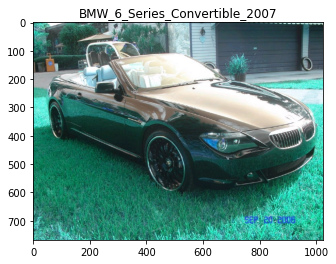

In [7]:
aaa = 2450

image = cv2.imread(paths[aaa])
plt.imshow(image)
plt.title(classes[num_class[aaa]])
print(image.shape)

In [8]:
# Read images and annotations
images = [os.path.join('datasets/cars/images', x) for x in os.listdir('datasets/cars/images')]
images.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_class, val_class = train_test_split(images, num_class, test_size = 0.2, random_state = 42)
val_images, test_images, val_class, test_class = train_test_split(val_images, val_class, test_size = 0.5, random_state = 42)

In [9]:
def move_files(file, folder):
    try:
        shutil.move(file, folder)
    except:
        print(file)
        raise
            
for i in range(len(train_images)):
    #print(train_images[i],' - ',classes[train_class[i]])
    move_files(train_images[i],'datasets/cars/train/{}/'.format(classes[train_class[i]]))
    
for i in range(len(test_images)):
    #print(train_images[i],' - ',classes[train_class[i]])
    move_files(test_images[i],'datasets/cars/test/{}/'.format(classes[test_class[i]]))
    
for i in range(len(val_images)):
    #print(train_images[i],' - ',classes[train_class[i]])
    move_files(val_images[i],'datasets/cars/valid/{}/'.format(classes[val_class[i]]))
    

In [10]:
!pwd
!ls datasets/cars/

/home/misael/Documentos/computer_vision/project
images	test  train  valid


In [11]:
path = 'datasets/cars'

train = os.listdir(path+'/train')
test = os.listdir(path+'/test')
valid = os.listdir(path+'/valid')

data_train = []
train_labels = []
for i in range(len(train)):
    aux = os.listdir(path+'/train/'+train[i])
    data_train.append(aux)
    train_labels.append(train[i])
    
data_test = []
test_labels = []
for i in range(len(test)):
    aux = os.listdir(path+'/test/'+test[i])
    data_test.append(aux)
    test_labels.append(test[i])
    
data_valid = []
valid_labels = []
for i in range(len(valid)):
    aux = os.listdir(path+'/valid/'+valid[i])
    data_valid.append(aux)
    valid_labels.append(valid[i])

In [12]:
train

['Hyundai_Santa_Fe_SUV_2012',
 'Scion_xD_Hatchback_2012',
 'Honda_Accord_Coupe_2012',
 'Chrysler_Sebring_Convertible_2010',
 'BMW_X3_SUV_2012',
 'Ford_Freestar_Minivan_2007',
 'Land_Rover_LR2_SUV_2012',
 'Aston_Martin_V8_Vantage_Coupe_2012',
 'Buick_Regal_GS_2012',
 'GMC_Savana_Van_2012',
 'Audi_S4_Sedan_2012',
 'BMW_M6_Convertible_2010',
 'Cadillac_CTS-V_Sedan_2012',
 'McLaren_MP4-12C_Coupe_2012',
 'BMW_1_Series_Coupe_2012',
 'Ford_F-150_Regular_Cab_2012',
 'Chevrolet_Corvette_ZR1_2012',
 'Chevrolet_TrailBlazer_SS_2009',
 'AM_General_Hummer_SUV_2000',
 'Suzuki_SX4_Hatchback_2012',
 'Audi_S5_Convertible_2012',
 'Chevrolet_Avalanche_Crew_Cab_2012',
 'Hyundai_Veloster_Hatchback_2012',
 'Ford_GT_Coupe_2006',
 'Jeep_Liberty_SUV_2012',
 'Audi_RS_4_Convertible_2008',
 'Chevrolet_Sonic_Sedan_2012',
 'Dodge_Durango_SUV_2012',
 'Dodge_Ram_Pickup_3500_Quad_Cab_2009',
 'Nissan_NV_Passenger_Van_2012',
 'BMW_X5_SUV_2007',
 'Daewoo_Nubira_Wagon_2002',
 'Hyundai_Accent_Sedan_2012',
 'Mazda_Tribute_SU

In [13]:
# Define the transforms to be performed over every subset instance
train_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
valid_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# Map the training and testing subsets 
train_data = datasets.ImageFolder(path+'/train', transform=train_transforms)
test_data = datasets.ImageFolder(path+'/test', transform=test_transforms)
valid_data = datasets.ImageFolder(path+'/valid', transform=valid_transforms)

batch_size = 256

# PyTorch data loaders
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_data, batch_size, shuffle=True, num_workers=0)

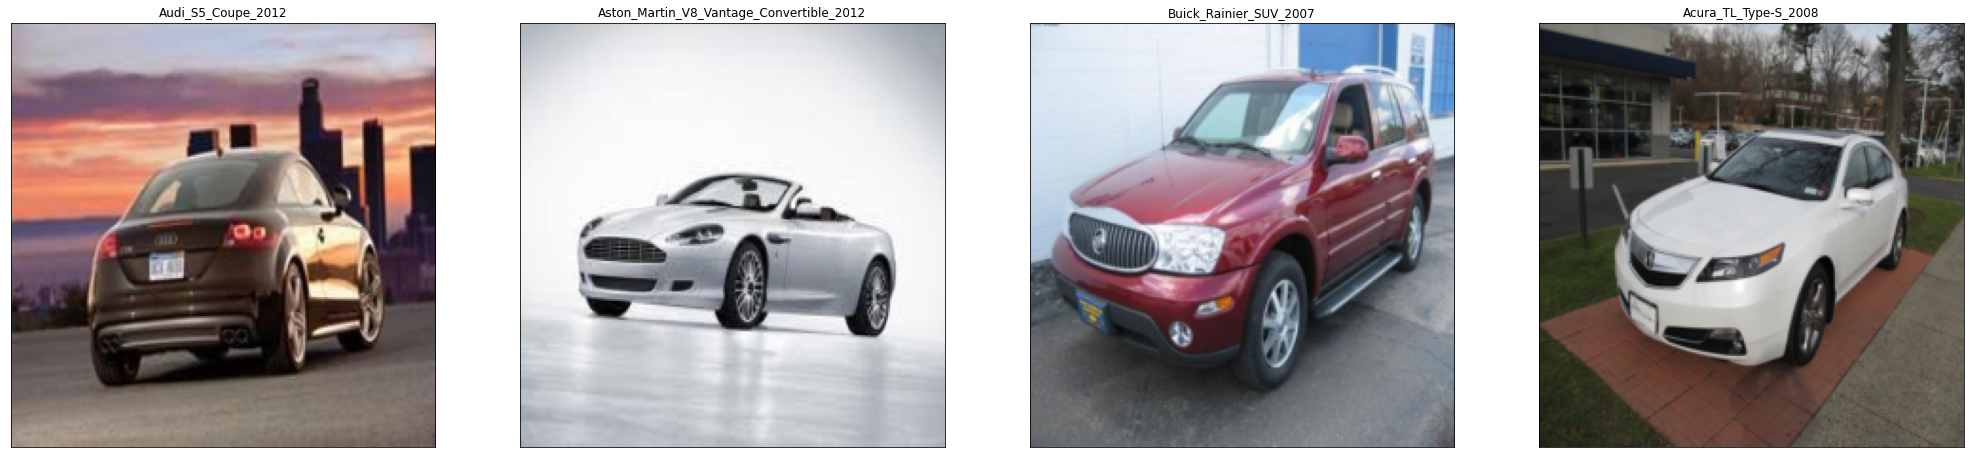

In [14]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.permute(0,2,3,1).numpy()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(35, 15))
for idx in range(0,4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx].numpy()])

In [16]:
# Load the pretrained model Alexnet
pretrained_model = models.alexnet(pretrained=True)
#pretrained_model = torch.load('datasets/model.pt')
pretrained_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
for idx, param in enumerate(pretrained_model.features.parameters()):
    param.required_grad = False
    print(param.size())
print()
for idx, param in enumerate(pretrained_model.classifier.parameters()):
    print(param.size())

torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])

torch.Size([4096, 9216])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([1000, 4096])
torch.Size([1000])


In [18]:
num = pretrained_model.classifier[1].in_features
feat = list(pretrained_model.classifier.children())[:-3]
feat

[Dropout(p=0.5, inplace=False),
 Linear(in_features=9216, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False)]

In [19]:
feat.extend([nn.Linear(4096, 2048)])
feat.extend([nn.ReLU(True)])
feat.extend([nn.Dropout(0.5,False)])
feat.extend([nn.Linear(2048, 512)])
feat.extend([nn.ReLU(True)])
feat.extend([nn.Dropout(0.5,False)])
feat.extend([nn.Linear(512, 196)])
feat.extend([nn.ReLU(True)])

pretrained_model.classifier = torch.nn.Sequential(*feat)
pretrained_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [20]:
for param in pretrained_model.classifier.parameters():
  param.requires_grad = True

### Retraining the model for the chosen dataset

In [21]:
# define a loss function
criterion = nn.CrossEntropyLoss()
# stochastic gradient descent with a small learning rate AND some momentum
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.003, momentum=0.9)

In [22]:
print(len(train_loader.dataset))

12948


In [23]:
# This time, we will use the GPU to train the model. So, don't forget to change 
# the runtime before running this cell. This might require to run the previous cells again.  
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
pretrained_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
# Define a function which takes in a number of epochs to train for. 
# this function return the total loss over time, which you can visualize if needed
def train(model, n_epochs):
    
    # to track the loss as the network trains
    loss_over_time = [] 
    
    # loop over the dataset multiple times
    for epoch in tqdm(range(n_epochs),total=n_epochs):  
        
        running_loss = 0.0
        avg_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):

            # get the input images and their corresponding labels
            inputs, labels = data
            # move inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 10 == 9:    # print every 1000 batches
                avg_loss = running_loss/10
                # record and print the avg loss over the 1000 batches
                
                print("Epoch: ",epoch + 1," Batch:",batch_i+1, "Avg. Loss: ",avg_loss)
                running_loss = 0.0
            
        loss_over_time.append(avg_loss)

    print('Finished Training')
    return loss_over_time

# define the number of epochs to train for
n_epochs = 300

# call train
training_loss = train(pretrained_model, n_epochs)

  0%|                                                   | 0/300 [00:00<?, ?it/s]

Epoch:  1  Batch: 10 Avg. Loss:  5.288331413269043
Epoch:  1  Batch: 20 Avg. Loss:  5.283345413208008
Epoch:  1  Batch: 30 Avg. Loss:  5.2853631496429445
Epoch:  1  Batch: 40 Avg. Loss:  5.276915740966797
Epoch:  1  Batch: 50 Avg. Loss:  5.274686431884765


  0%|▏                                        | 1/300 [01:16<6:19:28, 76.15s/it]

Epoch:  2  Batch: 10 Avg. Loss:  5.271583890914917
Epoch:  2  Batch: 20 Avg. Loss:  5.269641733169555
Epoch:  2  Batch: 30 Avg. Loss:  5.2696852684021
Epoch:  2  Batch: 40 Avg. Loss:  5.266904401779175
Epoch:  2  Batch: 50 Avg. Loss:  5.263810634613037


  1%|▎                                        | 2/300 [02:29<6:10:59, 74.70s/it]

Epoch:  3  Batch: 10 Avg. Loss:  5.252917909622193
Epoch:  3  Batch: 20 Avg. Loss:  5.253995609283447
Epoch:  3  Batch: 30 Avg. Loss:  5.2467920780181885
Epoch:  3  Batch: 40 Avg. Loss:  5.2342479705810545
Epoch:  3  Batch: 50 Avg. Loss:  5.238198280334473


  1%|▍                                        | 3/300 [03:41<6:02:39, 73.26s/it]

Epoch:  4  Batch: 10 Avg. Loss:  5.211508512496948
Epoch:  4  Batch: 20 Avg. Loss:  5.203902864456177
Epoch:  4  Batch: 30 Avg. Loss:  5.202630043029785
Epoch:  4  Batch: 40 Avg. Loss:  5.174765110015869
Epoch:  4  Batch: 50 Avg. Loss:  5.1632616996765135


  1%|▌                                        | 4/300 [04:53<5:59:30, 72.87s/it]

Epoch:  5  Batch: 10 Avg. Loss:  5.121211814880371
Epoch:  5  Batch: 20 Avg. Loss:  5.107364130020142
Epoch:  5  Batch: 30 Avg. Loss:  5.079335451126099
Epoch:  5  Batch: 40 Avg. Loss:  5.047533988952637
Epoch:  5  Batch: 50 Avg. Loss:  5.019434642791748


  2%|▋                                        | 5/300 [06:04<5:55:27, 72.30s/it]

Epoch:  6  Batch: 10 Avg. Loss:  4.9839301109313965
Epoch:  6  Batch: 20 Avg. Loss:  4.9198637962341305
Epoch:  6  Batch: 30 Avg. Loss:  4.898365497589111
Epoch:  6  Batch: 40 Avg. Loss:  4.861488389968872
Epoch:  6  Batch: 50 Avg. Loss:  4.815607690811158


  2%|▊                                        | 6/300 [07:15<5:52:01, 71.84s/it]

Epoch:  7  Batch: 10 Avg. Loss:  4.784469890594482
Epoch:  7  Batch: 20 Avg. Loss:  4.691977214813233
Epoch:  7  Batch: 30 Avg. Loss:  4.617217302322388
Epoch:  7  Batch: 40 Avg. Loss:  4.596703052520752
Epoch:  7  Batch: 50 Avg. Loss:  4.565972805023193


  2%|▉                                        | 7/300 [08:27<5:49:51, 71.64s/it]

Epoch:  8  Batch: 10 Avg. Loss:  4.449744129180909
Epoch:  8  Batch: 20 Avg. Loss:  4.416777420043945
Epoch:  8  Batch: 30 Avg. Loss:  4.358757448196411
Epoch:  8  Batch: 40 Avg. Loss:  4.305720806121826
Epoch:  8  Batch: 50 Avg. Loss:  4.234913635253906


  3%|█                                        | 8/300 [09:38<5:48:23, 71.59s/it]

Epoch:  9  Batch: 10 Avg. Loss:  4.156984138488769
Epoch:  9  Batch: 20 Avg. Loss:  4.121492576599121
Epoch:  9  Batch: 30 Avg. Loss:  4.100186848640442
Epoch:  9  Batch: 40 Avg. Loss:  4.040231728553772
Epoch:  9  Batch: 50 Avg. Loss:  3.9340206384658813


  3%|█▏                                       | 9/300 [10:50<5:48:01, 71.76s/it]

Epoch:  10  Batch: 10 Avg. Loss:  3.7641693115234376
Epoch:  10  Batch: 20 Avg. Loss:  3.7769049167633058
Epoch:  10  Batch: 30 Avg. Loss:  3.7731723546981812
Epoch:  10  Batch: 40 Avg. Loss:  3.6513415575027466
Epoch:  10  Batch: 50 Avg. Loss:  3.705967330932617


  3%|█▎                                      | 10/300 [12:02<5:46:17, 71.65s/it]

Epoch:  11  Batch: 10 Avg. Loss:  3.502802085876465
Epoch:  11  Batch: 20 Avg. Loss:  3.454124665260315
Epoch:  11  Batch: 30 Avg. Loss:  3.3218228578567506
Epoch:  11  Batch: 40 Avg. Loss:  3.333742642402649
Epoch:  11  Batch: 50 Avg. Loss:  3.315650749206543


  4%|█▍                                      | 11/300 [13:13<5:44:23, 71.50s/it]

Epoch:  12  Batch: 10 Avg. Loss:  3.162286972999573
Epoch:  12  Batch: 20 Avg. Loss:  3.103041100502014
Epoch:  12  Batch: 30 Avg. Loss:  3.079195332527161
Epoch:  12  Batch: 40 Avg. Loss:  3.04393048286438
Epoch:  12  Batch: 50 Avg. Loss:  3.0799288749694824


  4%|█▌                                      | 12/300 [14:25<5:43:43, 71.61s/it]

Epoch:  13  Batch: 10 Avg. Loss:  2.993852162361145
Epoch:  13  Batch: 20 Avg. Loss:  2.943573999404907
Epoch:  13  Batch: 30 Avg. Loss:  2.8314057111740114
Epoch:  13  Batch: 40 Avg. Loss:  2.827058744430542
Epoch:  13  Batch: 50 Avg. Loss:  2.7953539848327638


  4%|█▋                                      | 13/300 [15:36<5:41:42, 71.44s/it]

Epoch:  14  Batch: 10 Avg. Loss:  2.6539242267608643
Epoch:  14  Batch: 20 Avg. Loss:  2.570322585105896
Epoch:  14  Batch: 30 Avg. Loss:  2.542535662651062
Epoch:  14  Batch: 40 Avg. Loss:  2.4708317041397097
Epoch:  14  Batch: 50 Avg. Loss:  2.584765315055847


  5%|█▊                                      | 14/300 [16:47<5:40:39, 71.47s/it]

Epoch:  15  Batch: 10 Avg. Loss:  2.3173907518386843
Epoch:  15  Batch: 20 Avg. Loss:  2.3564252138137816
Epoch:  15  Batch: 30 Avg. Loss:  2.327402853965759
Epoch:  15  Batch: 40 Avg. Loss:  2.341491198539734
Epoch:  15  Batch: 50 Avg. Loss:  2.4864713668823244


  5%|██                                      | 15/300 [17:59<5:39:58, 71.57s/it]

Epoch:  16  Batch: 10 Avg. Loss:  2.172432518005371
Epoch:  16  Batch: 20 Avg. Loss:  2.082918846607208
Epoch:  16  Batch: 30 Avg. Loss:  2.1577066659927366
Epoch:  16  Batch: 40 Avg. Loss:  2.116978311538696
Epoch:  16  Batch: 50 Avg. Loss:  2.1591898798942566


  5%|██▏                                     | 16/300 [19:11<5:38:41, 71.55s/it]

Epoch:  17  Batch: 10 Avg. Loss:  1.9059298157691955
Epoch:  17  Batch: 20 Avg. Loss:  1.9626585006713868
Epoch:  17  Batch: 30 Avg. Loss:  1.9431572198867797
Epoch:  17  Batch: 40 Avg. Loss:  1.9657896518707276
Epoch:  17  Batch: 50 Avg. Loss:  2.006653928756714


  6%|██▎                                     | 17/300 [20:22<5:37:06, 71.47s/it]

Epoch:  18  Batch: 10 Avg. Loss:  1.9107975482940673
Epoch:  18  Batch: 20 Avg. Loss:  1.8922424077987672
Epoch:  18  Batch: 30 Avg. Loss:  1.811425268650055
Epoch:  18  Batch: 40 Avg. Loss:  1.7802878975868226
Epoch:  18  Batch: 50 Avg. Loss:  1.8136805176734925


  6%|██▍                                     | 18/300 [21:33<5:36:02, 71.50s/it]

Epoch:  19  Batch: 10 Avg. Loss:  1.6266817688941955
Epoch:  19  Batch: 20 Avg. Loss:  1.5748142004013062
Epoch:  19  Batch: 30 Avg. Loss:  1.6352214455604552
Epoch:  19  Batch: 40 Avg. Loss:  1.6129974722862244
Epoch:  19  Batch: 50 Avg. Loss:  1.680487048625946


  6%|██▌                                     | 19/300 [22:44<5:34:08, 71.35s/it]

Epoch:  20  Batch: 10 Avg. Loss:  1.460139846801758
Epoch:  20  Batch: 20 Avg. Loss:  1.5284479141235352
Epoch:  20  Batch: 30 Avg. Loss:  1.5187808990478515
Epoch:  20  Batch: 40 Avg. Loss:  1.5226283311843871
Epoch:  20  Batch: 50 Avg. Loss:  1.5149442434310914


  7%|██▋                                     | 20/300 [23:56<5:32:49, 71.32s/it]

Epoch:  21  Batch: 10 Avg. Loss:  1.2813670635223389
Epoch:  21  Batch: 20 Avg. Loss:  1.2938201785087586
Epoch:  21  Batch: 30 Avg. Loss:  1.3120297551155091
Epoch:  21  Batch: 40 Avg. Loss:  1.3140508651733398
Epoch:  21  Batch: 50 Avg. Loss:  1.3319473028182984


  7%|██▊                                     | 21/300 [25:06<5:30:52, 71.16s/it]

Epoch:  22  Batch: 10 Avg. Loss:  1.1662470698356628
Epoch:  22  Batch: 20 Avg. Loss:  1.1814704298973084
Epoch:  22  Batch: 30 Avg. Loss:  1.2272974371910095
Epoch:  22  Batch: 40 Avg. Loss:  1.2687177896499633
Epoch:  22  Batch: 50 Avg. Loss:  1.2200125336647034


  7%|██▉                                     | 22/300 [26:18<5:30:51, 71.41s/it]

Epoch:  23  Batch: 10 Avg. Loss:  1.0819496750831603
Epoch:  23  Batch: 20 Avg. Loss:  1.0976697623729705
Epoch:  23  Batch: 30 Avg. Loss:  1.1468813002109528
Epoch:  23  Batch: 40 Avg. Loss:  1.1376072287559509
Epoch:  23  Batch: 50 Avg. Loss:  1.2270745277404784


  8%|███                                     | 23/300 [27:30<5:29:41, 71.41s/it]

Epoch:  24  Batch: 10 Avg. Loss:  0.9894881010055542
Epoch:  24  Batch: 20 Avg. Loss:  0.9908546507358551
Epoch:  24  Batch: 30 Avg. Loss:  0.9571549773216248
Epoch:  24  Batch: 40 Avg. Loss:  1.0013664543628693
Epoch:  24  Batch: 50 Avg. Loss:  0.9729322910308837


  8%|███▏                                    | 24/300 [28:42<5:28:51, 71.49s/it]

Epoch:  25  Batch: 10 Avg. Loss:  0.9117425739765167
Epoch:  25  Batch: 20 Avg. Loss:  0.8647188067436218
Epoch:  25  Batch: 30 Avg. Loss:  0.8949013173580169
Epoch:  25  Batch: 40 Avg. Loss:  0.8630256891250611
Epoch:  25  Batch: 50 Avg. Loss:  0.9363272249698639


  8%|███▎                                    | 25/300 [29:53<5:27:25, 71.44s/it]

Epoch:  26  Batch: 10 Avg. Loss:  0.8321001470088959
Epoch:  26  Batch: 20 Avg. Loss:  0.7892362594604492
Epoch:  26  Batch: 30 Avg. Loss:  0.7966321766376495
Epoch:  26  Batch: 40 Avg. Loss:  0.8062058627605438
Epoch:  26  Batch: 50 Avg. Loss:  0.7497767925262451


  9%|███▍                                    | 26/300 [31:04<5:25:50, 71.35s/it]

Epoch:  27  Batch: 10 Avg. Loss:  0.6990806758403778
Epoch:  27  Batch: 20 Avg. Loss:  0.7237800002098084
Epoch:  27  Batch: 30 Avg. Loss:  0.6928033828735352
Epoch:  27  Batch: 40 Avg. Loss:  0.7376141309738159
Epoch:  27  Batch: 50 Avg. Loss:  0.8070819795131683


  9%|███▌                                    | 27/300 [32:16<5:25:04, 71.44s/it]

Epoch:  28  Batch: 10 Avg. Loss:  0.638802570104599
Epoch:  28  Batch: 20 Avg. Loss:  0.6920563220977783
Epoch:  28  Batch: 30 Avg. Loss:  0.6902634859085083
Epoch:  28  Batch: 40 Avg. Loss:  0.69251828789711
Epoch:  28  Batch: 50 Avg. Loss:  0.6914387345314026


  9%|███▋                                    | 28/300 [33:27<5:23:32, 71.37s/it]

Epoch:  29  Batch: 10 Avg. Loss:  0.5788405060768127
Epoch:  29  Batch: 20 Avg. Loss:  0.6403761684894562
Epoch:  29  Batch: 30 Avg. Loss:  0.6251293301582337
Epoch:  29  Batch: 40 Avg. Loss:  0.6635924458503724
Epoch:  29  Batch: 50 Avg. Loss:  0.6477414965629578


 10%|███▊                                    | 29/300 [34:38<5:22:31, 71.41s/it]

Epoch:  30  Batch: 10 Avg. Loss:  0.5030389130115509
Epoch:  30  Batch: 20 Avg. Loss:  0.5153895616531372
Epoch:  30  Batch: 30 Avg. Loss:  0.48002701103687284
Epoch:  30  Batch: 40 Avg. Loss:  0.5152230679988861
Epoch:  30  Batch: 50 Avg. Loss:  0.5561729967594147


 10%|████                                    | 30/300 [35:49<5:20:47, 71.29s/it]

Epoch:  31  Batch: 10 Avg. Loss:  0.47585101425647736
Epoch:  31  Batch: 20 Avg. Loss:  0.46181330382823943
Epoch:  31  Batch: 30 Avg. Loss:  0.46298298239707947
Epoch:  31  Batch: 40 Avg. Loss:  0.4731533110141754
Epoch:  31  Batch: 50 Avg. Loss:  0.5315937131643296


 10%|████▏                                   | 31/300 [37:01<5:19:55, 71.36s/it]

Epoch:  32  Batch: 10 Avg. Loss:  0.4204800546169281
Epoch:  32  Batch: 20 Avg. Loss:  0.4405758887529373
Epoch:  32  Batch: 30 Avg. Loss:  0.4197140634059906
Epoch:  32  Batch: 40 Avg. Loss:  0.42452266812324524
Epoch:  32  Batch: 50 Avg. Loss:  0.437070819735527


 11%|████▎                                   | 32/300 [38:12<5:18:49, 71.38s/it]

Epoch:  33  Batch: 10 Avg. Loss:  0.3665851950645447
Epoch:  33  Batch: 20 Avg. Loss:  0.3689031332731247
Epoch:  33  Batch: 30 Avg. Loss:  0.39249883592128754
Epoch:  33  Batch: 40 Avg. Loss:  0.4124479740858078
Epoch:  33  Batch: 50 Avg. Loss:  0.3790418207645416


 11%|████▍                                   | 33/300 [39:24<5:17:38, 71.38s/it]

Epoch:  34  Batch: 10 Avg. Loss:  0.32477703094482424
Epoch:  34  Batch: 20 Avg. Loss:  0.3593206614255905
Epoch:  34  Batch: 30 Avg. Loss:  0.36920197308063507
Epoch:  34  Batch: 40 Avg. Loss:  0.353305721282959
Epoch:  34  Batch: 50 Avg. Loss:  0.3736082255840302


 11%|████▌                                   | 34/300 [40:35<5:16:42, 71.44s/it]

Epoch:  35  Batch: 10 Avg. Loss:  0.3329139679670334
Epoch:  35  Batch: 20 Avg. Loss:  0.34139907658100127
Epoch:  35  Batch: 30 Avg. Loss:  0.3226767361164093
Epoch:  35  Batch: 40 Avg. Loss:  0.3280932903289795
Epoch:  35  Batch: 50 Avg. Loss:  0.302217036485672


 12%|████▋                                   | 35/300 [41:47<5:15:34, 71.45s/it]

Epoch:  36  Batch: 10 Avg. Loss:  0.2707380399107933
Epoch:  36  Batch: 20 Avg. Loss:  0.29876180440187455
Epoch:  36  Batch: 30 Avg. Loss:  0.30826605260372164
Epoch:  36  Batch: 40 Avg. Loss:  0.28215825855731963
Epoch:  36  Batch: 50 Avg. Loss:  0.27289298474788665


 12%|████▊                                   | 36/300 [42:59<5:14:53, 71.57s/it]

Epoch:  37  Batch: 10 Avg. Loss:  0.2699378117918968
Epoch:  37  Batch: 20 Avg. Loss:  0.2536732479929924
Epoch:  37  Batch: 30 Avg. Loss:  0.2544827669858932
Epoch:  37  Batch: 40 Avg. Loss:  0.2501577138900757
Epoch:  37  Batch: 50 Avg. Loss:  0.27855979800224306


 12%|████▉                                   | 37/300 [44:10<5:13:26, 71.51s/it]

Epoch:  38  Batch: 10 Avg. Loss:  0.2387202188372612
Epoch:  38  Batch: 20 Avg. Loss:  0.2370565727353096
Epoch:  38  Batch: 30 Avg. Loss:  0.23990830779075623
Epoch:  38  Batch: 40 Avg. Loss:  0.24105530381202697
Epoch:  38  Batch: 50 Avg. Loss:  0.2762185826897621


 13%|█████                                   | 38/300 [45:21<5:11:39, 71.37s/it]

Epoch:  39  Batch: 10 Avg. Loss:  0.28649872839450835
Epoch:  39  Batch: 20 Avg. Loss:  0.24407756626605986
Epoch:  39  Batch: 30 Avg. Loss:  0.23449329882860184
Epoch:  39  Batch: 40 Avg. Loss:  0.2662692815065384
Epoch:  39  Batch: 50 Avg. Loss:  0.26419575065374373


 13%|█████▏                                  | 39/300 [46:31<5:09:11, 71.08s/it]

Epoch:  40  Batch: 10 Avg. Loss:  0.23255078196525575
Epoch:  40  Batch: 20 Avg. Loss:  0.22714894264936447
Epoch:  40  Batch: 30 Avg. Loss:  0.2129138931632042
Epoch:  40  Batch: 40 Avg. Loss:  0.22278219908475877
Epoch:  40  Batch: 50 Avg. Loss:  0.23598199039697648


 13%|█████▎                                  | 40/300 [47:40<5:04:38, 70.30s/it]

Epoch:  41  Batch: 10 Avg. Loss:  0.19475155770778657
Epoch:  41  Batch: 20 Avg. Loss:  0.19283624440431596
Epoch:  41  Batch: 30 Avg. Loss:  0.18521000444889069
Epoch:  41  Batch: 40 Avg. Loss:  0.20213824063539504
Epoch:  41  Batch: 50 Avg. Loss:  0.22736359834671022


 14%|█████▍                                  | 41/300 [48:48<5:00:55, 69.71s/it]

Epoch:  42  Batch: 10 Avg. Loss:  0.17594052255153655
Epoch:  42  Batch: 20 Avg. Loss:  0.17933023273944854
Epoch:  42  Batch: 30 Avg. Loss:  0.17259023934602738
Epoch:  42  Batch: 40 Avg. Loss:  0.16631274968385695
Epoch:  42  Batch: 50 Avg. Loss:  0.19997301399707795


 14%|█████▌                                  | 42/300 [49:56<4:57:47, 69.25s/it]

Epoch:  43  Batch: 10 Avg. Loss:  0.17440861612558364
Epoch:  43  Batch: 20 Avg. Loss:  0.18058157637715339
Epoch:  43  Batch: 30 Avg. Loss:  0.18147353380918502
Epoch:  43  Batch: 40 Avg. Loss:  0.16812202855944633
Epoch:  43  Batch: 50 Avg. Loss:  0.14614461585879326


 14%|█████▋                                  | 43/300 [51:05<4:55:46, 69.05s/it]

Epoch:  44  Batch: 10 Avg. Loss:  0.14812852963805198
Epoch:  44  Batch: 20 Avg. Loss:  0.15309247598052025
Epoch:  44  Batch: 30 Avg. Loss:  0.15623993277549744
Epoch:  44  Batch: 40 Avg. Loss:  0.14709000140428544
Epoch:  44  Batch: 50 Avg. Loss:  0.1773720234632492


 15%|█████▊                                  | 44/300 [52:14<4:54:11, 68.95s/it]

Epoch:  45  Batch: 10 Avg. Loss:  0.15493630692362786
Epoch:  45  Batch: 20 Avg. Loss:  0.14790790230035783
Epoch:  45  Batch: 30 Avg. Loss:  0.15593925714492798
Epoch:  45  Batch: 40 Avg. Loss:  0.14718944653868676
Epoch:  45  Batch: 50 Avg. Loss:  0.16384679898619653


 15%|██████                                  | 45/300 [53:22<4:52:32, 68.83s/it]

Epoch:  46  Batch: 10 Avg. Loss:  0.15602944493293763
Epoch:  46  Batch: 20 Avg. Loss:  0.14723826050758362
Epoch:  46  Batch: 30 Avg. Loss:  0.1430776059627533
Epoch:  46  Batch: 40 Avg. Loss:  0.14357901066541673
Epoch:  46  Batch: 50 Avg. Loss:  0.1367002695798874


 15%|██████▏                                 | 46/300 [54:31<4:51:52, 68.95s/it]

Epoch:  47  Batch: 10 Avg. Loss:  0.12129319906234741
Epoch:  47  Batch: 20 Avg. Loss:  0.1415235683321953
Epoch:  47  Batch: 30 Avg. Loss:  0.11795866191387176
Epoch:  47  Batch: 40 Avg. Loss:  0.11701144278049469
Epoch:  47  Batch: 50 Avg. Loss:  0.15621328130364417


 16%|██████▎                                 | 47/300 [55:40<4:49:56, 68.76s/it]

Epoch:  48  Batch: 10 Avg. Loss:  0.1300471656024456
Epoch:  48  Batch: 20 Avg. Loss:  0.11048292145133018
Epoch:  48  Batch: 30 Avg. Loss:  0.10877608433365822
Epoch:  48  Batch: 40 Avg. Loss:  0.11835902109742165
Epoch:  48  Batch: 50 Avg. Loss:  0.1212026260793209


 16%|██████▍                                 | 48/300 [56:48<4:48:07, 68.60s/it]

Epoch:  49  Batch: 10 Avg. Loss:  0.09697187468409538
Epoch:  49  Batch: 20 Avg. Loss:  0.1124197356402874
Epoch:  49  Batch: 30 Avg. Loss:  0.11551065966486931
Epoch:  49  Batch: 40 Avg. Loss:  0.10394715964794159
Epoch:  49  Batch: 50 Avg. Loss:  0.1062364049255848


 16%|██████▌                                 | 49/300 [57:56<4:46:44, 68.54s/it]

Epoch:  50  Batch: 10 Avg. Loss:  0.11654999181628227
Epoch:  50  Batch: 20 Avg. Loss:  0.1125565953552723
Epoch:  50  Batch: 30 Avg. Loss:  0.11537021845579147
Epoch:  50  Batch: 40 Avg. Loss:  0.12165679037570953
Epoch:  50  Batch: 50 Avg. Loss:  0.12454780861735344


 17%|██████▋                                 | 50/300 [59:05<4:45:37, 68.55s/it]

Epoch:  51  Batch: 10 Avg. Loss:  0.11505039110779762
Epoch:  51  Batch: 20 Avg. Loss:  0.10486231297254563
Epoch:  51  Batch: 30 Avg. Loss:  0.09380402266979218
Epoch:  51  Batch: 40 Avg. Loss:  0.09714756645262242
Epoch:  51  Batch: 50 Avg. Loss:  0.11219235360622407


 17%|██████▍                               | 51/300 [1:00:13<4:44:19, 68.51s/it]

Epoch:  52  Batch: 10 Avg. Loss:  0.09290902800858021
Epoch:  52  Batch: 20 Avg. Loss:  0.09970598816871643
Epoch:  52  Batch: 30 Avg. Loss:  0.10852784663438797
Epoch:  52  Batch: 40 Avg. Loss:  0.10021686628460884
Epoch:  52  Batch: 50 Avg. Loss:  0.10377002283930778


 17%|██████▌                               | 52/300 [1:01:22<4:43:19, 68.54s/it]

Epoch:  53  Batch: 10 Avg. Loss:  0.07812822498381138
Epoch:  53  Batch: 20 Avg. Loss:  0.10027058273553849
Epoch:  53  Batch: 30 Avg. Loss:  0.10554086491465568
Epoch:  53  Batch: 40 Avg. Loss:  0.11106876730918884
Epoch:  53  Batch: 50 Avg. Loss:  0.08331813067197799


 18%|██████▋                               | 53/300 [1:02:30<4:41:52, 68.47s/it]

Epoch:  54  Batch: 10 Avg. Loss:  0.0747510738670826
Epoch:  54  Batch: 20 Avg. Loss:  0.09765565022826195
Epoch:  54  Batch: 30 Avg. Loss:  0.09387258142232895
Epoch:  54  Batch: 40 Avg. Loss:  0.10461319535970688
Epoch:  54  Batch: 50 Avg. Loss:  0.09907332509756088


 18%|██████▊                               | 54/300 [1:03:39<4:40:37, 68.44s/it]

Epoch:  55  Batch: 10 Avg. Loss:  0.0807233065366745
Epoch:  55  Batch: 20 Avg. Loss:  0.09017141498625278
Epoch:  55  Batch: 30 Avg. Loss:  0.0946151215583086
Epoch:  55  Batch: 40 Avg. Loss:  0.10384271666407585
Epoch:  55  Batch: 50 Avg. Loss:  0.10914739370346069


 18%|██████▉                               | 55/300 [1:04:48<4:39:54, 68.55s/it]

Epoch:  56  Batch: 10 Avg. Loss:  0.08997245356440545
Epoch:  56  Batch: 20 Avg. Loss:  0.08910313658416272
Epoch:  56  Batch: 30 Avg. Loss:  0.0928446501493454
Epoch:  56  Batch: 40 Avg. Loss:  0.08404603376984596
Epoch:  56  Batch: 50 Avg. Loss:  0.07568960003554821


 19%|███████                               | 56/300 [1:05:56<4:38:53, 68.58s/it]

Epoch:  57  Batch: 10 Avg. Loss:  0.08106226846575737
Epoch:  57  Batch: 20 Avg. Loss:  0.08732012920081615
Epoch:  57  Batch: 30 Avg. Loss:  0.06982870511710644
Epoch:  57  Batch: 40 Avg. Loss:  0.08173852562904357
Epoch:  57  Batch: 50 Avg. Loss:  0.08234589882194995


 19%|███████▏                              | 57/300 [1:07:04<4:36:55, 68.38s/it]

Epoch:  58  Batch: 10 Avg. Loss:  0.08141919523477555
Epoch:  58  Batch: 20 Avg. Loss:  0.07089267000555992
Epoch:  58  Batch: 30 Avg. Loss:  0.07779435403645038
Epoch:  58  Batch: 40 Avg. Loss:  0.08561588376760483
Epoch:  58  Batch: 50 Avg. Loss:  0.07477266117930412


 19%|███████▎                              | 58/300 [1:08:13<4:36:54, 68.65s/it]

Epoch:  59  Batch: 10 Avg. Loss:  0.06301748342812061
Epoch:  59  Batch: 20 Avg. Loss:  0.05701715014874935
Epoch:  59  Batch: 30 Avg. Loss:  0.07251998446881772
Epoch:  59  Batch: 40 Avg. Loss:  0.07444371841847897
Epoch:  59  Batch: 50 Avg. Loss:  0.07704059705138207


 20%|███████▍                              | 59/300 [1:09:22<4:35:35, 68.61s/it]

Epoch:  60  Batch: 10 Avg. Loss:  0.07750001065433025
Epoch:  60  Batch: 20 Avg. Loss:  0.07278985306620597
Epoch:  60  Batch: 30 Avg. Loss:  0.08059190213680267
Epoch:  60  Batch: 40 Avg. Loss:  0.07623935528099537
Epoch:  60  Batch: 50 Avg. Loss:  0.09159509614109992


 20%|███████▌                              | 60/300 [1:10:30<4:34:07, 68.53s/it]

Epoch:  61  Batch: 10 Avg. Loss:  0.067136737331748
Epoch:  61  Batch: 20 Avg. Loss:  0.07017289847135544
Epoch:  61  Batch: 30 Avg. Loss:  0.07663546577095985
Epoch:  61  Batch: 40 Avg. Loss:  0.07231227904558182
Epoch:  61  Batch: 50 Avg. Loss:  0.06064403988420963


 20%|███████▋                              | 61/300 [1:11:39<4:33:01, 68.54s/it]

Epoch:  62  Batch: 10 Avg. Loss:  0.07111239098012448
Epoch:  62  Batch: 20 Avg. Loss:  0.07361329086124897
Epoch:  62  Batch: 30 Avg. Loss:  0.07717995159327984
Epoch:  62  Batch: 40 Avg. Loss:  0.06405160315334797
Epoch:  62  Batch: 50 Avg. Loss:  0.08055996671319007


 21%|███████▊                              | 62/300 [1:12:47<4:31:39, 68.49s/it]

Epoch:  63  Batch: 10 Avg. Loss:  0.06443541422486306
Epoch:  63  Batch: 20 Avg. Loss:  0.060986589454114434
Epoch:  63  Batch: 30 Avg. Loss:  0.06514019779860973
Epoch:  63  Batch: 40 Avg. Loss:  0.06041837371885776
Epoch:  63  Batch: 50 Avg. Loss:  0.07502834238111973


 21%|███████▉                              | 63/300 [1:13:56<4:31:00, 68.61s/it]

Epoch:  64  Batch: 10 Avg. Loss:  0.0574872488155961
Epoch:  64  Batch: 20 Avg. Loss:  0.059160555526614186
Epoch:  64  Batch: 30 Avg. Loss:  0.05898040570318699
Epoch:  64  Batch: 40 Avg. Loss:  0.056431261636316774
Epoch:  64  Batch: 50 Avg. Loss:  0.06760889776051045


 21%|████████                              | 64/300 [1:15:04<4:29:36, 68.54s/it]

Epoch:  65  Batch: 10 Avg. Loss:  0.05068345163017511
Epoch:  65  Batch: 20 Avg. Loss:  0.06266866810619831
Epoch:  65  Batch: 30 Avg. Loss:  0.05455265361815691
Epoch:  65  Batch: 40 Avg. Loss:  0.07379574999213219
Epoch:  65  Batch: 50 Avg. Loss:  0.04929432235658169


 22%|████████▏                             | 65/300 [1:16:13<4:28:58, 68.67s/it]

Epoch:  66  Batch: 10 Avg. Loss:  0.04733994510024786
Epoch:  66  Batch: 20 Avg. Loss:  0.05554975122213364
Epoch:  66  Batch: 30 Avg. Loss:  0.059357987716794014
Epoch:  66  Batch: 40 Avg. Loss:  0.06879776827991009
Epoch:  66  Batch: 50 Avg. Loss:  0.06801526732742787


 22%|████████▎                             | 66/300 [1:17:22<4:27:33, 68.60s/it]

Epoch:  67  Batch: 10 Avg. Loss:  0.04910302367061377
Epoch:  67  Batch: 20 Avg. Loss:  0.06747024357318879
Epoch:  67  Batch: 30 Avg. Loss:  0.06680328473448753
Epoch:  67  Batch: 40 Avg. Loss:  0.05398743934929371
Epoch:  67  Batch: 50 Avg. Loss:  0.059742330200970174


 22%|████████▍                             | 67/300 [1:18:31<4:26:34, 68.65s/it]

Epoch:  68  Batch: 10 Avg. Loss:  0.05095741990953684
Epoch:  68  Batch: 20 Avg. Loss:  0.046553933061659336
Epoch:  68  Batch: 30 Avg. Loss:  0.053910909593105315
Epoch:  68  Batch: 40 Avg. Loss:  0.055957137048244475
Epoch:  68  Batch: 50 Avg. Loss:  0.05968357697129249


 23%|████████▌                             | 68/300 [1:19:38<4:24:21, 68.37s/it]

Epoch:  69  Batch: 10 Avg. Loss:  0.038666604273021224
Epoch:  69  Batch: 20 Avg. Loss:  0.056116255559027196
Epoch:  69  Batch: 30 Avg. Loss:  0.051516162045300004
Epoch:  69  Batch: 40 Avg. Loss:  0.05451584421098232
Epoch:  69  Batch: 50 Avg. Loss:  0.05242716409265995


 23%|████████▋                             | 69/300 [1:20:47<4:23:11, 68.36s/it]

Epoch:  70  Batch: 10 Avg. Loss:  0.04902771227061749
Epoch:  70  Batch: 20 Avg. Loss:  0.05925616808235645
Epoch:  70  Batch: 30 Avg. Loss:  0.04756421763449907
Epoch:  70  Batch: 40 Avg. Loss:  0.04952475167810917
Epoch:  70  Batch: 50 Avg. Loss:  0.05269559342414141


 23%|████████▊                             | 70/300 [1:21:55<4:22:31, 68.48s/it]

Epoch:  71  Batch: 10 Avg. Loss:  0.04286116287112236
Epoch:  71  Batch: 20 Avg. Loss:  0.0438411021605134
Epoch:  71  Batch: 30 Avg. Loss:  0.04001917820423841
Epoch:  71  Batch: 40 Avg. Loss:  0.04505267348140478
Epoch:  71  Batch: 50 Avg. Loss:  0.06633364707231522


 24%|████████▉                             | 71/300 [1:23:04<4:21:30, 68.52s/it]

Epoch:  72  Batch: 10 Avg. Loss:  0.05426400862634182
Epoch:  72  Batch: 20 Avg. Loss:  0.0400037731975317
Epoch:  72  Batch: 30 Avg. Loss:  0.055830779299139974
Epoch:  72  Batch: 40 Avg. Loss:  0.046312617138028145
Epoch:  72  Batch: 50 Avg. Loss:  0.0451843049377203


 24%|█████████                             | 72/300 [1:24:13<4:21:12, 68.74s/it]

Epoch:  73  Batch: 10 Avg. Loss:  0.047073671407997605
Epoch:  73  Batch: 20 Avg. Loss:  0.04571458473801613
Epoch:  73  Batch: 30 Avg. Loss:  0.03808804769068956
Epoch:  73  Batch: 40 Avg. Loss:  0.04617617446929216
Epoch:  73  Batch: 50 Avg. Loss:  0.047741247713565825


 24%|█████████▏                            | 73/300 [1:25:22<4:19:57, 68.71s/it]

Epoch:  74  Batch: 10 Avg. Loss:  0.03793289680033922
Epoch:  74  Batch: 20 Avg. Loss:  0.0451302396133542
Epoch:  74  Batch: 30 Avg. Loss:  0.04607907440513372
Epoch:  74  Batch: 40 Avg. Loss:  0.05159868653863668
Epoch:  74  Batch: 50 Avg. Loss:  0.04984893724322319


 25%|█████████▎                            | 74/300 [1:26:30<4:18:36, 68.65s/it]

Epoch:  75  Batch: 10 Avg. Loss:  0.0493832902982831
Epoch:  75  Batch: 20 Avg. Loss:  0.04794516824185848
Epoch:  75  Batch: 30 Avg. Loss:  0.04312764834612608
Epoch:  75  Batch: 40 Avg. Loss:  0.038321052119135855
Epoch:  75  Batch: 50 Avg. Loss:  0.04451626092195511


 25%|█████████▌                            | 75/300 [1:27:39<4:17:00, 68.54s/it]

Epoch:  76  Batch: 10 Avg. Loss:  0.03597111795097589
Epoch:  76  Batch: 20 Avg. Loss:  0.0428327701985836
Epoch:  76  Batch: 30 Avg. Loss:  0.0466938866302371
Epoch:  76  Batch: 40 Avg. Loss:  0.03781140688806772
Epoch:  76  Batch: 50 Avg. Loss:  0.04298381358385086


 25%|█████████▋                            | 76/300 [1:28:47<4:15:27, 68.43s/it]

Epoch:  77  Batch: 10 Avg. Loss:  0.04342586454004049
Epoch:  77  Batch: 20 Avg. Loss:  0.03307889644056559
Epoch:  77  Batch: 30 Avg. Loss:  0.038944955356419085
Epoch:  77  Batch: 40 Avg. Loss:  0.04016860015690327
Epoch:  77  Batch: 50 Avg. Loss:  0.048784812167286876


 26%|█████████▊                            | 77/300 [1:29:55<4:13:52, 68.31s/it]

Epoch:  78  Batch: 10 Avg. Loss:  0.04189315773546696
Epoch:  78  Batch: 20 Avg. Loss:  0.04021563958376646
Epoch:  78  Batch: 30 Avg. Loss:  0.03948712423443794
Epoch:  78  Batch: 40 Avg. Loss:  0.047515908069908616
Epoch:  78  Batch: 50 Avg. Loss:  0.048257768526673316


 26%|█████████▉                            | 78/300 [1:31:03<4:12:07, 68.14s/it]

Epoch:  79  Batch: 10 Avg. Loss:  0.043197636120021345
Epoch:  79  Batch: 20 Avg. Loss:  0.039415127411484716
Epoch:  79  Batch: 30 Avg. Loss:  0.042521442845463754
Epoch:  79  Batch: 40 Avg. Loss:  0.03989498764276504
Epoch:  79  Batch: 50 Avg. Loss:  0.04114616420120001


 26%|██████████                            | 79/300 [1:32:11<4:11:07, 68.18s/it]

Epoch:  80  Batch: 10 Avg. Loss:  0.04521679636090994
Epoch:  80  Batch: 20 Avg. Loss:  0.0394000249914825
Epoch:  80  Batch: 30 Avg. Loss:  0.02780205011367798
Epoch:  80  Batch: 40 Avg. Loss:  0.04646671283990145
Epoch:  80  Batch: 50 Avg. Loss:  0.04961609710007906


 27%|██████████▏                           | 80/300 [1:33:19<4:09:47, 68.12s/it]

Epoch:  81  Batch: 10 Avg. Loss:  0.039049672149121764
Epoch:  81  Batch: 20 Avg. Loss:  0.03269257191568613
Epoch:  81  Batch: 30 Avg. Loss:  0.03349230717867613
Epoch:  81  Batch: 40 Avg. Loss:  0.039659479074180125
Epoch:  81  Batch: 50 Avg. Loss:  0.04571392759680748


 27%|██████████▎                           | 81/300 [1:34:27<4:08:50, 68.17s/it]

Epoch:  82  Batch: 10 Avg. Loss:  0.04495147410780191
Epoch:  82  Batch: 20 Avg. Loss:  0.030237160623073578
Epoch:  82  Batch: 30 Avg. Loss:  0.040130427572876215
Epoch:  82  Batch: 40 Avg. Loss:  0.036925305426120755
Epoch:  82  Batch: 50 Avg. Loss:  0.04913100730627775


 27%|██████████▍                           | 82/300 [1:35:36<4:08:36, 68.42s/it]

Epoch:  83  Batch: 10 Avg. Loss:  0.045682307705283164
Epoch:  83  Batch: 20 Avg. Loss:  0.05158780850470066
Epoch:  83  Batch: 30 Avg. Loss:  0.03433136837556958
Epoch:  83  Batch: 40 Avg. Loss:  0.04989316798746586
Epoch:  83  Batch: 50 Avg. Loss:  0.03593115694820881


 28%|██████████▌                           | 83/300 [1:36:44<4:06:56, 68.28s/it]

Epoch:  84  Batch: 10 Avg. Loss:  0.03338473085314035
Epoch:  84  Batch: 20 Avg. Loss:  0.03350301552563906
Epoch:  84  Batch: 30 Avg. Loss:  0.039121207967400554
Epoch:  84  Batch: 40 Avg. Loss:  0.03100385284051299
Epoch:  84  Batch: 50 Avg. Loss:  0.044033732265233994


 28%|██████████▋                           | 84/300 [1:37:53<4:06:30, 68.48s/it]

Epoch:  85  Batch: 10 Avg. Loss:  0.03958138395100832
Epoch:  85  Batch: 20 Avg. Loss:  0.030067322589457036
Epoch:  85  Batch: 30 Avg. Loss:  0.04071546234190464
Epoch:  85  Batch: 40 Avg. Loss:  0.03608812419697642
Epoch:  85  Batch: 50 Avg. Loss:  0.029393996484577654


 28%|██████████▊                           | 85/300 [1:39:02<4:05:19, 68.46s/it]

Epoch:  86  Batch: 10 Avg. Loss:  0.03384174630045891
Epoch:  86  Batch: 20 Avg. Loss:  0.034345857240259646
Epoch:  86  Batch: 30 Avg. Loss:  0.03802290931344032
Epoch:  86  Batch: 40 Avg. Loss:  0.03017343133687973
Epoch:  86  Batch: 50 Avg. Loss:  0.040149946603924035


 29%|██████████▉                           | 86/300 [1:40:10<4:04:05, 68.44s/it]

Epoch:  87  Batch: 10 Avg. Loss:  0.03328629285097122
Epoch:  87  Batch: 20 Avg. Loss:  0.034557628072798253
Epoch:  87  Batch: 30 Avg. Loss:  0.03704061172902584
Epoch:  87  Batch: 40 Avg. Loss:  0.03954431973397732
Epoch:  87  Batch: 50 Avg. Loss:  0.029907257482409477


 29%|███████████                           | 87/300 [1:41:19<4:03:32, 68.60s/it]

Epoch:  88  Batch: 10 Avg. Loss:  0.03718779440969229
Epoch:  88  Batch: 20 Avg. Loss:  0.03511961437761783
Epoch:  88  Batch: 30 Avg. Loss:  0.037681592628359795
Epoch:  88  Batch: 40 Avg. Loss:  0.03429995086044073
Epoch:  88  Batch: 50 Avg. Loss:  0.0303509128279984


 29%|███████████▏                          | 88/300 [1:42:28<4:02:25, 68.61s/it]

Epoch:  89  Batch: 10 Avg. Loss:  0.025933253299444913
Epoch:  89  Batch: 20 Avg. Loss:  0.04008738156408072
Epoch:  89  Batch: 30 Avg. Loss:  0.03456444144248962
Epoch:  89  Batch: 40 Avg. Loss:  0.03125691218301654
Epoch:  89  Batch: 50 Avg. Loss:  0.03589906506240368


 30%|███████████▎                          | 89/300 [1:43:36<4:01:28, 68.67s/it]

Epoch:  90  Batch: 10 Avg. Loss:  0.03723370600491762
Epoch:  90  Batch: 20 Avg. Loss:  0.04291112935170531
Epoch:  90  Batch: 30 Avg. Loss:  0.030358737520873546
Epoch:  90  Batch: 40 Avg. Loss:  0.01940804272890091
Epoch:  90  Batch: 50 Avg. Loss:  0.03315519141033292


 30%|███████████▍                          | 90/300 [1:44:44<3:59:41, 68.48s/it]

Epoch:  91  Batch: 10 Avg. Loss:  0.030367001332342623
Epoch:  91  Batch: 20 Avg. Loss:  0.022039484046399594
Epoch:  91  Batch: 30 Avg. Loss:  0.030277020670473574
Epoch:  91  Batch: 40 Avg. Loss:  0.03878062786534429
Epoch:  91  Batch: 50 Avg. Loss:  0.031061256490647792


 30%|███████████▌                          | 91/300 [1:45:54<3:59:13, 68.68s/it]

Epoch:  92  Batch: 10 Avg. Loss:  0.03039775714278221
Epoch:  92  Batch: 20 Avg. Loss:  0.0305516604334116
Epoch:  92  Batch: 30 Avg. Loss:  0.026286412868648766
Epoch:  92  Batch: 40 Avg. Loss:  0.027300049923360346
Epoch:  92  Batch: 50 Avg. Loss:  0.036347695905715224


 31%|███████████▋                          | 92/300 [1:47:02<3:57:57, 68.64s/it]

Epoch:  93  Batch: 10 Avg. Loss:  0.034175760298967364
Epoch:  93  Batch: 20 Avg. Loss:  0.03000916913151741
Epoch:  93  Batch: 30 Avg. Loss:  0.028558954130858183
Epoch:  93  Batch: 40 Avg. Loss:  0.023406555084511636
Epoch:  93  Batch: 50 Avg. Loss:  0.03266809536144137


 31%|███████████▊                          | 93/300 [1:48:11<3:56:43, 68.61s/it]

Epoch:  94  Batch: 10 Avg. Loss:  0.027281424961984158
Epoch:  94  Batch: 20 Avg. Loss:  0.024509943602606655
Epoch:  94  Batch: 30 Avg. Loss:  0.02538984129205346
Epoch:  94  Batch: 40 Avg. Loss:  0.028337176796048878
Epoch:  94  Batch: 50 Avg. Loss:  0.03419976131990552


 31%|███████████▉                          | 94/300 [1:49:19<3:55:43, 68.66s/it]

Epoch:  95  Batch: 10 Avg. Loss:  0.02289841203019023
Epoch:  95  Batch: 20 Avg. Loss:  0.019743309216573836
Epoch:  95  Batch: 30 Avg. Loss:  0.03302115546539426
Epoch:  95  Batch: 40 Avg. Loss:  0.028197575267404316
Epoch:  95  Batch: 50 Avg. Loss:  0.036089887470006944


 32%|████████████                          | 95/300 [1:50:28<3:54:36, 68.67s/it]

Epoch:  96  Batch: 10 Avg. Loss:  0.024114450626075267
Epoch:  96  Batch: 20 Avg. Loss:  0.029068483039736748
Epoch:  96  Batch: 30 Avg. Loss:  0.031845223344862464
Epoch:  96  Batch: 40 Avg. Loss:  0.0313312953338027
Epoch:  96  Batch: 50 Avg. Loss:  0.031741033960133794


 32%|████████████▏                         | 96/300 [1:51:36<3:52:31, 68.39s/it]

Epoch:  97  Batch: 10 Avg. Loss:  0.023336678650230168
Epoch:  97  Batch: 20 Avg. Loss:  0.028287209663540126
Epoch:  97  Batch: 30 Avg. Loss:  0.03740140553563833
Epoch:  97  Batch: 40 Avg. Loss:  0.030926072038710117
Epoch:  97  Batch: 50 Avg. Loss:  0.03608345231041312


 32%|████████████▎                         | 97/300 [1:52:44<3:51:22, 68.39s/it]

Epoch:  98  Batch: 10 Avg. Loss:  0.02775307446718216
Epoch:  98  Batch: 20 Avg. Loss:  0.02440719697624445
Epoch:  98  Batch: 30 Avg. Loss:  0.03630787804722786
Epoch:  98  Batch: 40 Avg. Loss:  0.034133093804121016
Epoch:  98  Batch: 50 Avg. Loss:  0.04147346355021


 33%|████████████▍                         | 98/300 [1:53:52<3:50:02, 68.33s/it]

Epoch:  99  Batch: 10 Avg. Loss:  0.036743199825286864
Epoch:  99  Batch: 20 Avg. Loss:  0.025292730890214443
Epoch:  99  Batch: 30 Avg. Loss:  0.02150757908821106
Epoch:  99  Batch: 40 Avg. Loss:  0.023842001054435968
Epoch:  99  Batch: 50 Avg. Loss:  0.03899683486670256


 33%|████████████▌                         | 99/300 [1:55:01<3:49:27, 68.49s/it]

Epoch:  100  Batch: 10 Avg. Loss:  0.03700097426772118
Epoch:  100  Batch: 20 Avg. Loss:  0.024886737670749427
Epoch:  100  Batch: 30 Avg. Loss:  0.02995656607672572
Epoch:  100  Batch: 40 Avg. Loss:  0.033034052886068824
Epoch:  100  Batch: 50 Avg. Loss:  0.02481853049248457


 33%|████████████▎                        | 100/300 [1:56:10<3:48:18, 68.49s/it]

Epoch:  101  Batch: 10 Avg. Loss:  0.023781306762248277
Epoch:  101  Batch: 20 Avg. Loss:  0.02289833789691329
Epoch:  101  Batch: 30 Avg. Loss:  0.0316206599585712
Epoch:  101  Batch: 40 Avg. Loss:  0.019310608971863985
Epoch:  101  Batch: 50 Avg. Loss:  0.023117233533412218


 34%|████████████▍                        | 101/300 [1:57:18<3:47:16, 68.52s/it]

Epoch:  102  Batch: 10 Avg. Loss:  0.016769969277083872
Epoch:  102  Batch: 20 Avg. Loss:  0.023946256656199694
Epoch:  102  Batch: 30 Avg. Loss:  0.023241880256682633
Epoch:  102  Batch: 40 Avg. Loss:  0.022628914378583432
Epoch:  102  Batch: 50 Avg. Loss:  0.025858758203685283


 34%|████████████▌                        | 102/300 [1:58:26<3:45:18, 68.28s/it]

Epoch:  103  Batch: 10 Avg. Loss:  0.024214222095906734
Epoch:  103  Batch: 20 Avg. Loss:  0.026008795760571957
Epoch:  103  Batch: 30 Avg. Loss:  0.027773964498192073
Epoch:  103  Batch: 40 Avg. Loss:  0.02039238978177309
Epoch:  103  Batch: 50 Avg. Loss:  0.028477238863706587


 34%|████████████▋                        | 103/300 [1:59:35<3:44:23, 68.34s/it]

Epoch:  104  Batch: 10 Avg. Loss:  0.034666836634278296
Epoch:  104  Batch: 20 Avg. Loss:  0.026570878643542527
Epoch:  104  Batch: 30 Avg. Loss:  0.0251991861499846
Epoch:  104  Batch: 40 Avg. Loss:  0.021318283304572104
Epoch:  104  Batch: 50 Avg. Loss:  0.020009120274335147


 35%|████████████▊                        | 104/300 [2:00:43<3:43:10, 68.32s/it]

Epoch:  105  Batch: 10 Avg. Loss:  0.02064969385974109
Epoch:  105  Batch: 20 Avg. Loss:  0.021129127731546758
Epoch:  105  Batch: 30 Avg. Loss:  0.02131776725873351
Epoch:  105  Batch: 40 Avg. Loss:  0.02327550477348268
Epoch:  105  Batch: 50 Avg. Loss:  0.024755590595304966


 35%|████████████▉                        | 105/300 [2:01:51<3:42:11, 68.36s/it]

Epoch:  106  Batch: 10 Avg. Loss:  0.02088640397414565
Epoch:  106  Batch: 20 Avg. Loss:  0.02691524149850011
Epoch:  106  Batch: 30 Avg. Loss:  0.026198459975421428
Epoch:  106  Batch: 40 Avg. Loss:  0.02626811442896724
Epoch:  106  Batch: 50 Avg. Loss:  0.02246479280292988


 35%|█████████████                        | 106/300 [2:03:00<3:41:26, 68.49s/it]

Epoch:  107  Batch: 10 Avg. Loss:  0.030618885532021523
Epoch:  107  Batch: 20 Avg. Loss:  0.02847844026982784
Epoch:  107  Batch: 30 Avg. Loss:  0.023129259888082742
Epoch:  107  Batch: 40 Avg. Loss:  0.015981892077252268
Epoch:  107  Batch: 50 Avg. Loss:  0.023287137132138015


 36%|█████████████▏                       | 107/300 [2:04:08<3:40:08, 68.44s/it]

Epoch:  108  Batch: 10 Avg. Loss:  0.02559704575687647
Epoch:  108  Batch: 20 Avg. Loss:  0.01986489472910762
Epoch:  108  Batch: 30 Avg. Loss:  0.021926005370914936
Epoch:  108  Batch: 40 Avg. Loss:  0.018598343804478647
Epoch:  108  Batch: 50 Avg. Loss:  0.02309098104014993


 36%|█████████████▎                       | 108/300 [2:05:17<3:38:52, 68.40s/it]

Epoch:  109  Batch: 10 Avg. Loss:  0.018441028753295542
Epoch:  109  Batch: 20 Avg. Loss:  0.020778546435758473
Epoch:  109  Batch: 30 Avg. Loss:  0.023209814727306367
Epoch:  109  Batch: 40 Avg. Loss:  0.019880287908017637
Epoch:  109  Batch: 50 Avg. Loss:  0.02852882258594036


 36%|█████████████▍                       | 109/300 [2:06:25<3:37:53, 68.45s/it]

Epoch:  110  Batch: 10 Avg. Loss:  0.02794560929760337
Epoch:  110  Batch: 20 Avg. Loss:  0.018986439891159536
Epoch:  110  Batch: 30 Avg. Loss:  0.0239622600376606
Epoch:  110  Batch: 40 Avg. Loss:  0.023743212781846525
Epoch:  110  Batch: 50 Avg. Loss:  0.026316828839480878


 37%|█████████████▌                       | 110/300 [2:07:34<3:36:50, 68.48s/it]

Epoch:  111  Batch: 10 Avg. Loss:  0.027761009894311427
Epoch:  111  Batch: 20 Avg. Loss:  0.027006480703130366
Epoch:  111  Batch: 30 Avg. Loss:  0.022287761606276036
Epoch:  111  Batch: 40 Avg. Loss:  0.01951959412544966
Epoch:  111  Batch: 50 Avg. Loss:  0.03425581716001034


 37%|█████████████▋                       | 111/300 [2:08:43<3:36:00, 68.58s/it]

Epoch:  112  Batch: 10 Avg. Loss:  0.01923797558993101
Epoch:  112  Batch: 20 Avg. Loss:  0.018983378261327743
Epoch:  112  Batch: 30 Avg. Loss:  0.0255837423261255
Epoch:  112  Batch: 40 Avg. Loss:  0.02796669052913785
Epoch:  112  Batch: 50 Avg. Loss:  0.03180857012048364


 37%|█████████████▊                       | 112/300 [2:09:51<3:34:55, 68.59s/it]

Epoch:  113  Batch: 10 Avg. Loss:  0.022464699763804673
Epoch:  113  Batch: 20 Avg. Loss:  0.019104050798341633
Epoch:  113  Batch: 30 Avg. Loss:  0.020595233980566265
Epoch:  113  Batch: 40 Avg. Loss:  0.025404436513781548
Epoch:  113  Batch: 50 Avg. Loss:  0.022688418999314307


 38%|█████████████▉                       | 113/300 [2:11:00<3:33:30, 68.51s/it]

Epoch:  114  Batch: 10 Avg. Loss:  0.02020903108641505
Epoch:  114  Batch: 20 Avg. Loss:  0.018750414531677962
Epoch:  114  Batch: 30 Avg. Loss:  0.02243150696158409
Epoch:  114  Batch: 40 Avg. Loss:  0.024378833500668405
Epoch:  114  Batch: 50 Avg. Loss:  0.023698771791532635


 38%|██████████████                       | 114/300 [2:12:08<3:32:17, 68.48s/it]

Epoch:  115  Batch: 10 Avg. Loss:  0.014318798575550318
Epoch:  115  Batch: 20 Avg. Loss:  0.01512429742142558
Epoch:  115  Batch: 30 Avg. Loss:  0.015678239334374667
Epoch:  115  Batch: 40 Avg. Loss:  0.019407087471336126
Epoch:  115  Batch: 50 Avg. Loss:  0.02028532326221466


 38%|██████████████▏                      | 115/300 [2:13:16<3:30:40, 68.33s/it]

Epoch:  116  Batch: 10 Avg. Loss:  0.026479597203433514
Epoch:  116  Batch: 20 Avg. Loss:  0.02635286273434758
Epoch:  116  Batch: 30 Avg. Loss:  0.02472037528641522
Epoch:  116  Batch: 40 Avg. Loss:  0.01998429037630558
Epoch:  116  Batch: 50 Avg. Loss:  0.022365622315555812


 39%|██████████████▎                      | 116/300 [2:14:24<3:29:43, 68.39s/it]

Epoch:  117  Batch: 10 Avg. Loss:  0.01630543703213334
Epoch:  117  Batch: 20 Avg. Loss:  0.02836363362148404
Epoch:  117  Batch: 30 Avg. Loss:  0.01793477376922965
Epoch:  117  Batch: 40 Avg. Loss:  0.021213454753160478
Epoch:  117  Batch: 50 Avg. Loss:  0.018987083062529563


 39%|██████████████▍                      | 117/300 [2:15:32<3:28:13, 68.27s/it]

Epoch:  118  Batch: 10 Avg. Loss:  0.01584025495685637
Epoch:  118  Batch: 20 Avg. Loss:  0.022776994574815034
Epoch:  118  Batch: 30 Avg. Loss:  0.019169221818447112
Epoch:  118  Batch: 40 Avg. Loss:  0.01641532019712031
Epoch:  118  Batch: 50 Avg. Loss:  0.01792952106334269


 39%|██████████████▌                      | 118/300 [2:16:41<3:27:29, 68.40s/it]

Epoch:  119  Batch: 10 Avg. Loss:  0.01920161871239543
Epoch:  119  Batch: 20 Avg. Loss:  0.02225002637133002
Epoch:  119  Batch: 30 Avg. Loss:  0.021737905126065014
Epoch:  119  Batch: 40 Avg. Loss:  0.019486731197685004
Epoch:  119  Batch: 50 Avg. Loss:  0.0206782809458673


 40%|██████████████▋                      | 119/300 [2:17:49<3:26:11, 68.35s/it]

Epoch:  120  Batch: 10 Avg. Loss:  0.021828590612858533
Epoch:  120  Batch: 20 Avg. Loss:  0.020836908696219326
Epoch:  120  Batch: 30 Avg. Loss:  0.016566998092457652
Epoch:  120  Batch: 40 Avg. Loss:  0.02570470469072461
Epoch:  120  Batch: 50 Avg. Loss:  0.0177305918186903


 40%|██████████████▊                      | 120/300 [2:18:58<3:25:16, 68.43s/it]

Epoch:  121  Batch: 10 Avg. Loss:  0.018057779455557466
Epoch:  121  Batch: 20 Avg. Loss:  0.021724716387689115
Epoch:  121  Batch: 30 Avg. Loss:  0.020679926592856647
Epoch:  121  Batch: 40 Avg. Loss:  0.017622745502740143
Epoch:  121  Batch: 50 Avg. Loss:  0.023897215211763977


 40%|██████████████▉                      | 121/300 [2:20:07<3:24:23, 68.51s/it]

Epoch:  122  Batch: 10 Avg. Loss:  0.020898641645908357
Epoch:  122  Batch: 20 Avg. Loss:  0.021847569197416306
Epoch:  122  Batch: 30 Avg. Loss:  0.02019322905689478
Epoch:  122  Batch: 40 Avg. Loss:  0.014809401566162705
Epoch:  122  Batch: 50 Avg. Loss:  0.019235537527129053


 41%|███████████████                      | 122/300 [2:21:15<3:23:07, 68.47s/it]

Epoch:  123  Batch: 10 Avg. Loss:  0.01817175103351474
Epoch:  123  Batch: 20 Avg. Loss:  0.023600096348673105
Epoch:  123  Batch: 30 Avg. Loss:  0.02291945004835725
Epoch:  123  Batch: 40 Avg. Loss:  0.026412667986005545
Epoch:  123  Batch: 50 Avg. Loss:  0.021046622190624475


 41%|███████████████▏                     | 123/300 [2:22:24<3:22:29, 68.64s/it]

Epoch:  124  Batch: 10 Avg. Loss:  0.02352653592824936
Epoch:  124  Batch: 20 Avg. Loss:  0.01915160189382732
Epoch:  124  Batch: 30 Avg. Loss:  0.016124442778527738
Epoch:  124  Batch: 40 Avg. Loss:  0.016350640403106808
Epoch:  124  Batch: 50 Avg. Loss:  0.02011863365769386


 41%|███████████████▎                     | 124/300 [2:23:33<3:21:18, 68.63s/it]

Epoch:  125  Batch: 10 Avg. Loss:  0.020341917127370834
Epoch:  125  Batch: 20 Avg. Loss:  0.022771791089326143
Epoch:  125  Batch: 30 Avg. Loss:  0.018995070457458497
Epoch:  125  Batch: 40 Avg. Loss:  0.024227647949010132
Epoch:  125  Batch: 50 Avg. Loss:  0.020188728487119077


 42%|███████████████▍                     | 125/300 [2:24:41<3:19:57, 68.56s/it]

Epoch:  126  Batch: 10 Avg. Loss:  0.023185576871037485
Epoch:  126  Batch: 20 Avg. Loss:  0.027521871495991945
Epoch:  126  Batch: 30 Avg. Loss:  0.03034505797550082
Epoch:  126  Batch: 40 Avg. Loss:  0.020949698565527797
Epoch:  126  Batch: 50 Avg. Loss:  0.020106388442218303


 42%|███████████████▌                     | 126/300 [2:25:50<3:18:56, 68.60s/it]

Epoch:  127  Batch: 10 Avg. Loss:  0.02317519928328693
Epoch:  127  Batch: 20 Avg. Loss:  0.019125735107809304
Epoch:  127  Batch: 30 Avg. Loss:  0.02359776934608817
Epoch:  127  Batch: 40 Avg. Loss:  0.015211973246186972
Epoch:  127  Batch: 50 Avg. Loss:  0.01933023976162076


 42%|███████████████▋                     | 127/300 [2:26:58<3:17:48, 68.61s/it]

Epoch:  128  Batch: 10 Avg. Loss:  0.016009416477754713
Epoch:  128  Batch: 20 Avg. Loss:  0.01879906349349767
Epoch:  128  Batch: 30 Avg. Loss:  0.01886066810693592
Epoch:  128  Batch: 40 Avg. Loss:  0.015115707367658614
Epoch:  128  Batch: 50 Avg. Loss:  0.017907952656969428


 43%|███████████████▊                     | 128/300 [2:28:07<3:16:49, 68.66s/it]

Epoch:  129  Batch: 10 Avg. Loss:  0.013160184863954783
Epoch:  129  Batch: 20 Avg. Loss:  0.0186677691526711
Epoch:  129  Batch: 30 Avg. Loss:  0.011477745743468404
Epoch:  129  Batch: 40 Avg. Loss:  0.01919895811006427
Epoch:  129  Batch: 50 Avg. Loss:  0.01759304911829531


 43%|███████████████▉                     | 129/300 [2:29:16<3:15:28, 68.59s/it]

Epoch:  130  Batch: 10 Avg. Loss:  0.014029749622568487
Epoch:  130  Batch: 20 Avg. Loss:  0.018533393274992704
Epoch:  130  Batch: 30 Avg. Loss:  0.02552078920416534
Epoch:  130  Batch: 40 Avg. Loss:  0.023715936858206988
Epoch:  130  Batch: 50 Avg. Loss:  0.013941640872508288


 43%|████████████████                     | 130/300 [2:30:24<3:14:02, 68.49s/it]

Epoch:  131  Batch: 10 Avg. Loss:  0.013621469959616661
Epoch:  131  Batch: 20 Avg. Loss:  0.014386446867138147
Epoch:  131  Batch: 30 Avg. Loss:  0.014415071974508465
Epoch:  131  Batch: 40 Avg. Loss:  0.015530316065996886
Epoch:  131  Batch: 50 Avg. Loss:  0.014340773783624172


 44%|████████████████▏                    | 131/300 [2:31:32<3:12:29, 68.34s/it]

Epoch:  132  Batch: 10 Avg. Loss:  0.016463105892762543
Epoch:  132  Batch: 20 Avg. Loss:  0.016896886145696045
Epoch:  132  Batch: 30 Avg. Loss:  0.02440363271161914
Epoch:  132  Batch: 40 Avg. Loss:  0.020243968814611435
Epoch:  132  Batch: 50 Avg. Loss:  0.022580790147185326


 44%|████████████████▎                    | 132/300 [2:32:41<3:11:47, 68.50s/it]

Epoch:  133  Batch: 10 Avg. Loss:  0.01512725108768791
Epoch:  133  Batch: 20 Avg. Loss:  0.01918715313076973
Epoch:  133  Batch: 30 Avg. Loss:  0.018151871487498285
Epoch:  133  Batch: 40 Avg. Loss:  0.018058734945952892
Epoch:  133  Batch: 50 Avg. Loss:  0.02403480219654739


 44%|████████████████▍                    | 133/300 [2:33:49<3:10:23, 68.40s/it]

Epoch:  134  Batch: 10 Avg. Loss:  0.018222555052489042
Epoch:  134  Batch: 20 Avg. Loss:  0.018868110608309507
Epoch:  134  Batch: 30 Avg. Loss:  0.016983789997175334
Epoch:  134  Batch: 40 Avg. Loss:  0.01674180314876139
Epoch:  134  Batch: 50 Avg. Loss:  0.024114514328539373


 45%|████████████████▌                    | 134/300 [2:34:57<3:09:19, 68.43s/it]

Epoch:  135  Batch: 10 Avg. Loss:  0.017258663661777973
Epoch:  135  Batch: 20 Avg. Loss:  0.01977513814345002
Epoch:  135  Batch: 30 Avg. Loss:  0.013751880801282822
Epoch:  135  Batch: 40 Avg. Loss:  0.015137319592759014
Epoch:  135  Batch: 50 Avg. Loss:  0.019047404639422894


 45%|████████████████▋                    | 135/300 [2:36:06<3:07:59, 68.36s/it]

Epoch:  136  Batch: 10 Avg. Loss:  0.019293906819075345
Epoch:  136  Batch: 20 Avg. Loss:  0.012059922656044364
Epoch:  136  Batch: 30 Avg. Loss:  0.014031638228334486
Epoch:  136  Batch: 40 Avg. Loss:  0.016069304198026657
Epoch:  136  Batch: 50 Avg. Loss:  0.013575137848965824


 45%|████████████████▊                    | 136/300 [2:37:14<3:07:11, 68.49s/it]

Epoch:  137  Batch: 10 Avg. Loss:  0.014709010161459446
Epoch:  137  Batch: 20 Avg. Loss:  0.020725136855617166
Epoch:  137  Batch: 30 Avg. Loss:  0.015752368699759246
Epoch:  137  Batch: 40 Avg. Loss:  0.017167464690282942
Epoch:  137  Batch: 50 Avg. Loss:  0.01946756960824132


 46%|████████████████▉                    | 137/300 [2:38:23<3:05:48, 68.40s/it]

Epoch:  138  Batch: 10 Avg. Loss:  0.014534041518345475
Epoch:  138  Batch: 20 Avg. Loss:  0.019964212086051702
Epoch:  138  Batch: 30 Avg. Loss:  0.014549142308533191
Epoch:  138  Batch: 40 Avg. Loss:  0.01735779931768775
Epoch:  138  Batch: 50 Avg. Loss:  0.020594638679176568


 46%|█████████████████                    | 138/300 [2:39:31<3:04:30, 68.34s/it]

Epoch:  139  Batch: 10 Avg. Loss:  0.01569146467372775
Epoch:  139  Batch: 20 Avg. Loss:  0.018090143613517285
Epoch:  139  Batch: 30 Avg. Loss:  0.022502402681857346
Epoch:  139  Batch: 40 Avg. Loss:  0.02346193427219987
Epoch:  139  Batch: 50 Avg. Loss:  0.01879444213118404


 46%|█████████████████▏                   | 139/300 [2:40:39<3:03:36, 68.43s/it]

Epoch:  140  Batch: 10 Avg. Loss:  0.008930538035929202
Epoch:  140  Batch: 20 Avg. Loss:  0.013767153769731522
Epoch:  140  Batch: 30 Avg. Loss:  0.012636886117979884
Epoch:  140  Batch: 40 Avg. Loss:  0.01929254373535514
Epoch:  140  Batch: 50 Avg. Loss:  0.01986629031598568


 47%|█████████████████▎                   | 140/300 [2:41:47<3:01:50, 68.19s/it]

Epoch:  141  Batch: 10 Avg. Loss:  0.013048703502863645
Epoch:  141  Batch: 20 Avg. Loss:  0.0193310777656734
Epoch:  141  Batch: 30 Avg. Loss:  0.020829874533228578
Epoch:  141  Batch: 40 Avg. Loss:  0.019578416459262372
Epoch:  141  Batch: 50 Avg. Loss:  0.016002596286125482


 47%|█████████████████▍                   | 141/300 [2:42:56<3:01:11, 68.37s/it]

Epoch:  142  Batch: 10 Avg. Loss:  0.0200798605568707
Epoch:  142  Batch: 20 Avg. Loss:  0.011779882805421948
Epoch:  142  Batch: 30 Avg. Loss:  0.01967568169347942
Epoch:  142  Batch: 40 Avg. Loss:  0.021269793948158623
Epoch:  142  Batch: 50 Avg. Loss:  0.020685420697554947


 47%|█████████████████▌                   | 142/300 [2:44:05<3:00:28, 68.54s/it]

Epoch:  143  Batch: 10 Avg. Loss:  0.015202891128137708
Epoch:  143  Batch: 20 Avg. Loss:  0.01823411388322711
Epoch:  143  Batch: 30 Avg. Loss:  0.011149371834471821
Epoch:  143  Batch: 40 Avg. Loss:  0.022255202941596507
Epoch:  143  Batch: 50 Avg. Loss:  0.019618123630061747


 48%|█████████████████▋                   | 143/300 [2:45:13<2:59:03, 68.43s/it]

Epoch:  144  Batch: 10 Avg. Loss:  0.0198891191277653
Epoch:  144  Batch: 20 Avg. Loss:  0.013666244642809033
Epoch:  144  Batch: 30 Avg. Loss:  0.014895245060324669
Epoch:  144  Batch: 40 Avg. Loss:  0.015817720373161138
Epoch:  144  Batch: 50 Avg. Loss:  0.015751074231229723


 48%|█████████████████▊                   | 144/300 [2:46:21<2:57:27, 68.25s/it]

Epoch:  145  Batch: 10 Avg. Loss:  0.0143472156021744
Epoch:  145  Batch: 20 Avg. Loss:  0.012312896642833948
Epoch:  145  Batch: 30 Avg. Loss:  0.014321401808410883
Epoch:  145  Batch: 40 Avg. Loss:  0.012572666350752115
Epoch:  145  Batch: 50 Avg. Loss:  0.016788181266747415


 48%|█████████████████▉                   | 145/300 [2:47:29<2:56:09, 68.19s/it]

Epoch:  146  Batch: 10 Avg. Loss:  0.010611089505255222
Epoch:  146  Batch: 20 Avg. Loss:  0.012414140137843787
Epoch:  146  Batch: 30 Avg. Loss:  0.020396886672824622
Epoch:  146  Batch: 40 Avg. Loss:  0.014135260134935379
Epoch:  146  Batch: 50 Avg. Loss:  0.023865701537579297


 49%|██████████████████                   | 146/300 [2:48:38<2:55:32, 68.39s/it]

Epoch:  147  Batch: 10 Avg. Loss:  0.013735486171208322
Epoch:  147  Batch: 20 Avg. Loss:  0.011530960211530328
Epoch:  147  Batch: 30 Avg. Loss:  0.018495149537920953
Epoch:  147  Batch: 40 Avg. Loss:  0.011451266333460807
Epoch:  147  Batch: 50 Avg. Loss:  0.01519214005675167


 49%|██████████████████▏                  | 147/300 [2:49:46<2:54:07, 68.28s/it]

Epoch:  148  Batch: 10 Avg. Loss:  0.015640665986575188
Epoch:  148  Batch: 20 Avg. Loss:  0.015686946269124747
Epoch:  148  Batch: 30 Avg. Loss:  0.010782581870444119
Epoch:  148  Batch: 40 Avg. Loss:  0.021287108631804587
Epoch:  148  Batch: 50 Avg. Loss:  0.01824194591026753


 49%|██████████████████▎                  | 148/300 [2:50:54<2:52:55, 68.26s/it]

Epoch:  149  Batch: 10 Avg. Loss:  0.015209342841990292
Epoch:  149  Batch: 20 Avg. Loss:  0.020841680699959397
Epoch:  149  Batch: 30 Avg. Loss:  0.014664138853549957
Epoch:  149  Batch: 40 Avg. Loss:  0.02142297141253948
Epoch:  149  Batch: 50 Avg. Loss:  0.009674937138333917


 50%|██████████████████▍                  | 149/300 [2:52:02<2:51:40, 68.22s/it]

Epoch:  150  Batch: 10 Avg. Loss:  0.012303158082067967
Epoch:  150  Batch: 20 Avg. Loss:  0.01867378908209503
Epoch:  150  Batch: 30 Avg. Loss:  0.015160681051202118
Epoch:  150  Batch: 40 Avg. Loss:  0.012165395636111498
Epoch:  150  Batch: 50 Avg. Loss:  0.02034611878916621


 50%|██████████████████▌                  | 150/300 [2:53:11<2:50:47, 68.32s/it]

Epoch:  151  Batch: 10 Avg. Loss:  0.019760579615831376
Epoch:  151  Batch: 20 Avg. Loss:  0.019351625349372625
Epoch:  151  Batch: 30 Avg. Loss:  0.015730712050572037
Epoch:  151  Batch: 40 Avg. Loss:  0.013559779338538646
Epoch:  151  Batch: 50 Avg. Loss:  0.011141518619842828


 50%|██████████████████▌                  | 151/300 [2:54:19<2:49:53, 68.41s/it]

Epoch:  152  Batch: 10 Avg. Loss:  0.010626884177327156
Epoch:  152  Batch: 20 Avg. Loss:  0.018593121925368904
Epoch:  152  Batch: 30 Avg. Loss:  0.020144727150909602
Epoch:  152  Batch: 40 Avg. Loss:  0.013447604142129421
Epoch:  152  Batch: 50 Avg. Loss:  0.016063928860239683


 51%|██████████████████▋                  | 152/300 [2:55:27<2:48:36, 68.35s/it]

Epoch:  153  Batch: 10 Avg. Loss:  0.012373645394109189
Epoch:  153  Batch: 20 Avg. Loss:  0.009839027537964284
Epoch:  153  Batch: 30 Avg. Loss:  0.012176702031865716
Epoch:  153  Batch: 40 Avg. Loss:  0.018679902609437703
Epoch:  153  Batch: 50 Avg. Loss:  0.01821659444831312


 51%|██████████████████▊                  | 153/300 [2:56:36<2:47:23, 68.33s/it]

Epoch:  154  Batch: 10 Avg. Loss:  0.014003232307732105
Epoch:  154  Batch: 20 Avg. Loss:  0.012973878136835992
Epoch:  154  Batch: 30 Avg. Loss:  0.011930253868922592
Epoch:  154  Batch: 40 Avg. Loss:  0.015002972725778819
Epoch:  154  Batch: 50 Avg. Loss:  0.013693577260710299


 51%|██████████████████▉                  | 154/300 [2:57:44<2:46:23, 68.38s/it]

Epoch:  155  Batch: 10 Avg. Loss:  0.01591717153787613
Epoch:  155  Batch: 20 Avg. Loss:  0.017325780261307953
Epoch:  155  Batch: 30 Avg. Loss:  0.010514743230305611
Epoch:  155  Batch: 40 Avg. Loss:  0.01305838474072516
Epoch:  155  Batch: 50 Avg. Loss:  0.020578184351325034


 52%|███████████████████                  | 155/300 [2:58:53<2:45:16, 68.39s/it]

Epoch:  156  Batch: 10 Avg. Loss:  0.010641370108351112
Epoch:  156  Batch: 20 Avg. Loss:  0.00899655835237354
Epoch:  156  Batch: 30 Avg. Loss:  0.01533556953072548
Epoch:  156  Batch: 40 Avg. Loss:  0.013133561052381993
Epoch:  156  Batch: 50 Avg. Loss:  0.01698532826267183


 52%|███████████████████▏                 | 156/300 [3:00:02<2:44:29, 68.54s/it]

Epoch:  157  Batch: 10 Avg. Loss:  0.015410771174356342
Epoch:  157  Batch: 20 Avg. Loss:  0.011686423886567354
Epoch:  157  Batch: 30 Avg. Loss:  0.013432430289685725
Epoch:  157  Batch: 40 Avg. Loss:  0.015414930740371346
Epoch:  157  Batch: 50 Avg. Loss:  0.015668173553422093


 52%|███████████████████▎                 | 157/300 [3:01:10<2:43:06, 68.44s/it]

Epoch:  158  Batch: 10 Avg. Loss:  0.015521778631955386
Epoch:  158  Batch: 20 Avg. Loss:  0.016469855792820454
Epoch:  158  Batch: 30 Avg. Loss:  0.016650504618883132
Epoch:  158  Batch: 40 Avg. Loss:  0.0156865730881691
Epoch:  158  Batch: 50 Avg. Loss:  0.012363538541831077


 53%|███████████████████▍                 | 158/300 [3:02:18<2:42:05, 68.49s/it]

Epoch:  159  Batch: 10 Avg. Loss:  0.010766605730168521
Epoch:  159  Batch: 20 Avg. Loss:  0.010356853646226228
Epoch:  159  Batch: 30 Avg. Loss:  0.010882176482118667
Epoch:  159  Batch: 40 Avg. Loss:  0.012994308164343238
Epoch:  159  Batch: 50 Avg. Loss:  0.013203376950696111


 53%|███████████████████▌                 | 159/300 [3:03:26<2:40:26, 68.28s/it]

Epoch:  160  Batch: 10 Avg. Loss:  0.016015212028287353
Epoch:  160  Batch: 20 Avg. Loss:  0.013206100719980896
Epoch:  160  Batch: 30 Avg. Loss:  0.009630791051313281
Epoch:  160  Batch: 40 Avg. Loss:  0.014854591712355614
Epoch:  160  Batch: 50 Avg. Loss:  0.010021880688145756


 53%|███████████████████▋                 | 160/300 [3:04:34<2:39:17, 68.27s/it]

Epoch:  161  Batch: 10 Avg. Loss:  0.010013378062285482
Epoch:  161  Batch: 20 Avg. Loss:  0.008789934334345162
Epoch:  161  Batch: 30 Avg. Loss:  0.014141076151281596
Epoch:  161  Batch: 40 Avg. Loss:  0.011058614263311029
Epoch:  161  Batch: 50 Avg. Loss:  0.014213762199506163


 54%|███████████████████▊                 | 161/300 [3:05:43<2:38:30, 68.42s/it]

Epoch:  162  Batch: 10 Avg. Loss:  0.01858098027296364
Epoch:  162  Batch: 20 Avg. Loss:  0.01739573017694056
Epoch:  162  Batch: 30 Avg. Loss:  0.013333257823251187
Epoch:  162  Batch: 40 Avg. Loss:  0.01467612460255623
Epoch:  162  Batch: 50 Avg. Loss:  0.013096017227508128


 54%|███████████████████▉                 | 162/300 [3:06:51<2:36:52, 68.21s/it]

Epoch:  163  Batch: 10 Avg. Loss:  0.015957172168418764
Epoch:  163  Batch: 20 Avg. Loss:  0.01697929375804961
Epoch:  163  Batch: 30 Avg. Loss:  0.010262637725099921
Epoch:  163  Batch: 40 Avg. Loss:  0.014455938525497914
Epoch:  163  Batch: 50 Avg. Loss:  0.020031692925840616


 54%|████████████████████                 | 163/300 [3:07:59<2:35:44, 68.21s/it]

Epoch:  164  Batch: 10 Avg. Loss:  0.013387630973011256
Epoch:  164  Batch: 20 Avg. Loss:  0.009728493029251694
Epoch:  164  Batch: 30 Avg. Loss:  0.010042849066667258
Epoch:  164  Batch: 40 Avg. Loss:  0.020279040629975497
Epoch:  164  Batch: 50 Avg. Loss:  0.01819366291165352


 55%|████████████████████▏                | 164/300 [3:09:07<2:34:27, 68.14s/it]

Epoch:  165  Batch: 10 Avg. Loss:  0.01301060183905065
Epoch:  165  Batch: 20 Avg. Loss:  0.018782237032428383
Epoch:  165  Batch: 30 Avg. Loss:  0.01102945152670145
Epoch:  165  Batch: 40 Avg. Loss:  0.010483371163718402
Epoch:  165  Batch: 50 Avg. Loss:  0.015108052222058178


 55%|████████████████████▎                | 165/300 [3:10:16<2:33:57, 68.43s/it]

Epoch:  166  Batch: 10 Avg. Loss:  0.017338135931640863
Epoch:  166  Batch: 20 Avg. Loss:  0.010953112714923918
Epoch:  166  Batch: 30 Avg. Loss:  0.01667380714789033
Epoch:  166  Batch: 40 Avg. Loss:  0.012212817929685116
Epoch:  166  Batch: 50 Avg. Loss:  0.012671564961783588


 55%|████████████████████▍                | 166/300 [3:11:25<2:32:47, 68.41s/it]

Epoch:  167  Batch: 10 Avg. Loss:  0.00844882575329393
Epoch:  167  Batch: 20 Avg. Loss:  0.01153837596066296
Epoch:  167  Batch: 30 Avg. Loss:  0.010724869603291155
Epoch:  167  Batch: 40 Avg. Loss:  0.013902534311637283
Epoch:  167  Batch: 50 Avg. Loss:  0.011069650296121836


 56%|████████████████████▌                | 167/300 [3:12:33<2:31:32, 68.37s/it]

Epoch:  168  Batch: 10 Avg. Loss:  0.019542057579383255
Epoch:  168  Batch: 20 Avg. Loss:  0.012087587127462029
Epoch:  168  Batch: 30 Avg. Loss:  0.010992808314040304
Epoch:  168  Batch: 40 Avg. Loss:  0.009368601778987795
Epoch:  168  Batch: 50 Avg. Loss:  0.016475350316613912


 56%|████████████████████▋                | 168/300 [3:13:41<2:30:16, 68.30s/it]

Epoch:  169  Batch: 10 Avg. Loss:  0.012024009809829294
Epoch:  169  Batch: 20 Avg. Loss:  0.014677742193453015
Epoch:  169  Batch: 30 Avg. Loss:  0.01506616808474064
Epoch:  169  Batch: 40 Avg. Loss:  0.015372117841616273
Epoch:  169  Batch: 50 Avg. Loss:  0.01584423503372818


 56%|████████████████████▊                | 169/300 [3:14:50<2:29:28, 68.46s/it]

Epoch:  170  Batch: 10 Avg. Loss:  0.013040039828047157
Epoch:  170  Batch: 20 Avg. Loss:  0.008818113734014333
Epoch:  170  Batch: 30 Avg. Loss:  0.013970634574070573
Epoch:  170  Batch: 40 Avg. Loss:  0.012005141424015164
Epoch:  170  Batch: 50 Avg. Loss:  0.016014249785803257


 57%|████████████████████▉                | 170/300 [3:15:58<2:27:56, 68.28s/it]

Epoch:  171  Batch: 10 Avg. Loss:  0.01365815286990255
Epoch:  171  Batch: 20 Avg. Loss:  0.0095827222103253
Epoch:  171  Batch: 30 Avg. Loss:  0.0187080979347229
Epoch:  171  Batch: 40 Avg. Loss:  0.015753509616479276
Epoch:  171  Batch: 50 Avg. Loss:  0.012641421146690845


 57%|█████████████████████                | 171/300 [3:17:05<2:26:29, 68.13s/it]

Epoch:  172  Batch: 10 Avg. Loss:  0.015159385278820992
Epoch:  172  Batch: 20 Avg. Loss:  0.011464965669438243
Epoch:  172  Batch: 30 Avg. Loss:  0.011295384727418423
Epoch:  172  Batch: 40 Avg. Loss:  0.01425940627232194
Epoch:  172  Batch: 50 Avg. Loss:  0.012724747834727167


 57%|█████████████████████▏               | 172/300 [3:18:13<2:25:09, 68.04s/it]

Epoch:  173  Batch: 10 Avg. Loss:  0.010873147891834379
Epoch:  173  Batch: 20 Avg. Loss:  0.011269349558278918
Epoch:  173  Batch: 30 Avg. Loss:  0.009816685458645225
Epoch:  173  Batch: 40 Avg. Loss:  0.017326714494265615
Epoch:  173  Batch: 50 Avg. Loss:  0.008047574432566762


 58%|█████████████████████▎               | 173/300 [3:19:22<2:24:31, 68.28s/it]

Epoch:  174  Batch: 10 Avg. Loss:  0.014004828408360481
Epoch:  174  Batch: 20 Avg. Loss:  0.015059795405250043
Epoch:  174  Batch: 30 Avg. Loss:  0.013715523295104504
Epoch:  174  Batch: 40 Avg. Loss:  0.015406793542206287
Epoch:  174  Batch: 50 Avg. Loss:  0.014855641592293977


 58%|█████████████████████▍               | 174/300 [3:20:31<2:23:34, 68.37s/it]

Epoch:  175  Batch: 10 Avg. Loss:  0.012955708988010883
Epoch:  175  Batch: 20 Avg. Loss:  0.012416595080867409
Epoch:  175  Batch: 30 Avg. Loss:  0.014953769464045762
Epoch:  175  Batch: 40 Avg. Loss:  0.016418949398212136
Epoch:  175  Batch: 50 Avg. Loss:  0.019287445629015566


 58%|█████████████████████▌               | 175/300 [3:21:39<2:22:39, 68.47s/it]

Epoch:  176  Batch: 10 Avg. Loss:  0.014034525817260146
Epoch:  176  Batch: 20 Avg. Loss:  0.012921514688059688
Epoch:  176  Batch: 30 Avg. Loss:  0.016891328943893315
Epoch:  176  Batch: 40 Avg. Loss:  0.014198941877111793
Epoch:  176  Batch: 50 Avg. Loss:  0.011446655169129372


 59%|█████████████████████▋               | 176/300 [3:22:47<2:21:16, 68.36s/it]

Epoch:  177  Batch: 10 Avg. Loss:  0.007967639807611704
Epoch:  177  Batch: 20 Avg. Loss:  0.0187341142911464
Epoch:  177  Batch: 30 Avg. Loss:  0.016519872518256307
Epoch:  177  Batch: 40 Avg. Loss:  0.01406090680975467
Epoch:  177  Batch: 50 Avg. Loss:  0.008969438634812832


 59%|█████████████████████▊               | 177/300 [3:23:56<2:20:16, 68.43s/it]

Epoch:  178  Batch: 10 Avg. Loss:  0.009168837824836374
Epoch:  178  Batch: 20 Avg. Loss:  0.010703674610704183
Epoch:  178  Batch: 30 Avg. Loss:  0.013613982615061105
Epoch:  178  Batch: 40 Avg. Loss:  0.015524804918095469
Epoch:  178  Batch: 50 Avg. Loss:  0.016258748061954976


 59%|█████████████████████▉               | 178/300 [3:25:05<2:19:10, 68.44s/it]

Epoch:  179  Batch: 10 Avg. Loss:  0.013587090047076344
Epoch:  179  Batch: 20 Avg. Loss:  0.01463076900690794
Epoch:  179  Batch: 30 Avg. Loss:  0.015456793503835798
Epoch:  179  Batch: 40 Avg. Loss:  0.01185152360703796
Epoch:  179  Batch: 50 Avg. Loss:  0.013850742811337113


 60%|██████████████████████               | 179/300 [3:26:13<2:18:07, 68.49s/it]

Epoch:  180  Batch: 10 Avg. Loss:  0.00933343255892396
Epoch:  180  Batch: 20 Avg. Loss:  0.011915269983001053
Epoch:  180  Batch: 30 Avg. Loss:  0.01508965778630227
Epoch:  180  Batch: 40 Avg. Loss:  0.01051995491143316
Epoch:  180  Batch: 50 Avg. Loss:  0.009554340410977602


 60%|██████████████████████▏              | 180/300 [3:27:21<2:16:32, 68.27s/it]

Epoch:  181  Batch: 10 Avg. Loss:  0.010864502424374223
Epoch:  181  Batch: 20 Avg. Loss:  0.012451195204630495
Epoch:  181  Batch: 30 Avg. Loss:  0.009328449261374772
Epoch:  181  Batch: 40 Avg. Loss:  0.012263668410014361
Epoch:  181  Batch: 50 Avg. Loss:  0.01791580766439438


 60%|██████████████████████▎              | 181/300 [3:28:30<2:15:40, 68.41s/it]

Epoch:  182  Batch: 10 Avg. Loss:  0.014498586626723408
Epoch:  182  Batch: 20 Avg. Loss:  0.01454666005447507
Epoch:  182  Batch: 30 Avg. Loss:  0.012825370021164417
Epoch:  182  Batch: 40 Avg. Loss:  0.013916084170341491
Epoch:  182  Batch: 50 Avg. Loss:  0.011690763151273131


 61%|██████████████████████▍              | 182/300 [3:29:38<2:14:17, 68.28s/it]

Epoch:  183  Batch: 10 Avg. Loss:  0.012897032569162548
Epoch:  183  Batch: 20 Avg. Loss:  0.013777082320302725
Epoch:  183  Batch: 30 Avg. Loss:  0.01225864894222468
Epoch:  183  Batch: 40 Avg. Loss:  0.010386128933168948
Epoch:  183  Batch: 50 Avg. Loss:  0.010881045344285667


 61%|██████████████████████▌              | 183/300 [3:30:46<2:13:05, 68.25s/it]

Epoch:  184  Batch: 10 Avg. Loss:  0.008536701393313705
Epoch:  184  Batch: 20 Avg. Loss:  0.005757346842437982
Epoch:  184  Batch: 30 Avg. Loss:  0.00885534449480474
Epoch:  184  Batch: 40 Avg. Loss:  0.012132865143939853
Epoch:  184  Batch: 50 Avg. Loss:  0.012390940356999636


 61%|██████████████████████▋              | 184/300 [3:31:54<2:12:00, 68.28s/it]

Epoch:  185  Batch: 10 Avg. Loss:  0.014431346068158745
Epoch:  185  Batch: 20 Avg. Loss:  0.009213324449956418
Epoch:  185  Batch: 30 Avg. Loss:  0.01124463346786797
Epoch:  185  Batch: 40 Avg. Loss:  0.010525181330740452
Epoch:  185  Batch: 50 Avg. Loss:  0.010914864100050181


 62%|██████████████████████▊              | 185/300 [3:33:03<2:10:56, 68.32s/it]

Epoch:  186  Batch: 10 Avg. Loss:  0.011777178361080587
Epoch:  186  Batch: 20 Avg. Loss:  0.009972414933145046
Epoch:  186  Batch: 30 Avg. Loss:  0.010174425598233939
Epoch:  186  Batch: 40 Avg. Loss:  0.014244181290268897
Epoch:  186  Batch: 50 Avg. Loss:  0.01065741889178753


 62%|██████████████████████▉              | 186/300 [3:34:11<2:09:43, 68.28s/it]

Epoch:  187  Batch: 10 Avg. Loss:  0.007791351433843375
Epoch:  187  Batch: 20 Avg. Loss:  0.00914711570367217
Epoch:  187  Batch: 30 Avg. Loss:  0.010530449356883765
Epoch:  187  Batch: 40 Avg. Loss:  0.010315028205513953
Epoch:  187  Batch: 50 Avg. Loss:  0.01338711716234684


 62%|███████████████████████              | 187/300 [3:35:19<2:08:30, 68.23s/it]

Epoch:  188  Batch: 10 Avg. Loss:  0.012281618569977582
Epoch:  188  Batch: 20 Avg. Loss:  0.009325858170632273
Epoch:  188  Batch: 30 Avg. Loss:  0.010167751787230372
Epoch:  188  Batch: 40 Avg. Loss:  0.01038451335625723
Epoch:  188  Batch: 50 Avg. Loss:  0.013978775218129158


 63%|███████████████████████▏             | 188/300 [3:36:27<2:07:34, 68.34s/it]

Epoch:  189  Batch: 10 Avg. Loss:  0.008434606727678328
Epoch:  189  Batch: 20 Avg. Loss:  0.011082617891952395
Epoch:  189  Batch: 30 Avg. Loss:  0.006967810052447021
Epoch:  189  Batch: 40 Avg. Loss:  0.010230685595888644
Epoch:  189  Batch: 50 Avg. Loss:  0.013395400112494826


 63%|███████████████████████▎             | 189/300 [3:37:36<2:06:16, 68.26s/it]

Epoch:  190  Batch: 10 Avg. Loss:  0.008613257249817253
Epoch:  190  Batch: 20 Avg. Loss:  0.015382299106568098
Epoch:  190  Batch: 30 Avg. Loss:  0.009128610184416176
Epoch:  190  Batch: 40 Avg. Loss:  0.008719100971939042
Epoch:  190  Batch: 50 Avg. Loss:  0.015763748856261372


 63%|███████████████████████▍             | 190/300 [3:38:44<2:05:06, 68.24s/it]

Epoch:  191  Batch: 10 Avg. Loss:  0.0075675005442462865
Epoch:  191  Batch: 20 Avg. Loss:  0.010473900614306331
Epoch:  191  Batch: 30 Avg. Loss:  0.011236642464064061
Epoch:  191  Batch: 40 Avg. Loss:  0.015486532787326724
Epoch:  191  Batch: 50 Avg. Loss:  0.013493727799504996


 64%|███████████████████████▌             | 191/300 [3:39:52<2:04:01, 68.27s/it]

Epoch:  192  Batch: 10 Avg. Loss:  0.009433274064213038
Epoch:  192  Batch: 20 Avg. Loss:  0.013260800461284816
Epoch:  192  Batch: 30 Avg. Loss:  0.015064360247924924
Epoch:  192  Batch: 40 Avg. Loss:  0.011562774935737253
Epoch:  192  Batch: 50 Avg. Loss:  0.007607011555228383


 64%|███████████████████████▋             | 192/300 [3:41:00<2:02:52, 68.26s/it]

Epoch:  193  Batch: 10 Avg. Loss:  0.009562115115113557
Epoch:  193  Batch: 20 Avg. Loss:  0.01400818359106779
Epoch:  193  Batch: 30 Avg. Loss:  0.010765507211908698
Epoch:  193  Batch: 40 Avg. Loss:  0.011155739217065275
Epoch:  193  Batch: 50 Avg. Loss:  0.011228423193097114


 64%|███████████████████████▊             | 193/300 [3:42:09<2:01:51, 68.33s/it]

Epoch:  194  Batch: 10 Avg. Loss:  0.008674264803994447
Epoch:  194  Batch: 20 Avg. Loss:  0.011981852864846588
Epoch:  194  Batch: 30 Avg. Loss:  0.010042753955349325
Epoch:  194  Batch: 40 Avg. Loss:  0.013542820559814572
Epoch:  194  Batch: 50 Avg. Loss:  0.011082368530333042


 65%|███████████████████████▉             | 194/300 [3:43:17<2:00:35, 68.26s/it]

Epoch:  195  Batch: 10 Avg. Loss:  0.007702490972587839
Epoch:  195  Batch: 20 Avg. Loss:  0.011836475040763617
Epoch:  195  Batch: 30 Avg. Loss:  0.009740304667502642
Epoch:  195  Batch: 40 Avg. Loss:  0.010623949859291316
Epoch:  195  Batch: 50 Avg. Loss:  0.009658018732443452


 65%|████████████████████████             | 195/300 [3:44:25<1:59:36, 68.35s/it]

Epoch:  196  Batch: 10 Avg. Loss:  0.009386636246927083
Epoch:  196  Batch: 20 Avg. Loss:  0.008768475987017155
Epoch:  196  Batch: 30 Avg. Loss:  0.011388530593831093
Epoch:  196  Batch: 40 Avg. Loss:  0.009551769657991826
Epoch:  196  Batch: 50 Avg. Loss:  0.01734385814052075


 65%|████████████████████████▏            | 196/300 [3:45:34<1:58:31, 68.38s/it]

Epoch:  197  Batch: 10 Avg. Loss:  0.010752926697023213
Epoch:  197  Batch: 20 Avg. Loss:  0.010362738254480064
Epoch:  197  Batch: 30 Avg. Loss:  0.013688400725368411
Epoch:  197  Batch: 40 Avg. Loss:  0.01448819269426167
Epoch:  197  Batch: 50 Avg. Loss:  0.014867334486916661


 66%|████████████████████████▎            | 197/300 [3:46:42<1:57:15, 68.30s/it]

Epoch:  198  Batch: 10 Avg. Loss:  0.008910908515099436
Epoch:  198  Batch: 20 Avg. Loss:  0.010043353587388993
Epoch:  198  Batch: 30 Avg. Loss:  0.011424283171072603
Epoch:  198  Batch: 40 Avg. Loss:  0.01555638964055106
Epoch:  198  Batch: 50 Avg. Loss:  0.011625374387949704


 66%|████████████████████████▍            | 198/300 [3:47:50<1:56:01, 68.25s/it]

Epoch:  199  Batch: 10 Avg. Loss:  0.00784927539061755
Epoch:  199  Batch: 20 Avg. Loss:  0.011674316308926791
Epoch:  199  Batch: 30 Avg. Loss:  0.010786199267022312
Epoch:  199  Batch: 40 Avg. Loss:  0.015074852434918285
Epoch:  199  Batch: 50 Avg. Loss:  0.012477306730579585


 66%|████████████████████████▌            | 199/300 [3:48:59<1:55:16, 68.48s/it]

Epoch:  200  Batch: 10 Avg. Loss:  0.014838629262521863
Epoch:  200  Batch: 20 Avg. Loss:  0.010976970754563808
Epoch:  200  Batch: 30 Avg. Loss:  0.007754459884017706
Epoch:  200  Batch: 40 Avg. Loss:  0.020011669071391226
Epoch:  200  Batch: 50 Avg. Loss:  0.013164321286603808


 67%|████████████████████████▋            | 200/300 [3:50:08<1:54:09, 68.50s/it]

Epoch:  201  Batch: 10 Avg. Loss:  0.007741873525083065
Epoch:  201  Batch: 20 Avg. Loss:  0.00965744354762137
Epoch:  201  Batch: 30 Avg. Loss:  0.011831502197310328
Epoch:  201  Batch: 40 Avg. Loss:  0.011021899757906795
Epoch:  201  Batch: 50 Avg. Loss:  0.013087324774824083


 67%|████████████████████████▊            | 201/300 [3:51:16<1:53:08, 68.57s/it]

Epoch:  202  Batch: 10 Avg. Loss:  0.006218695198185742
Epoch:  202  Batch: 20 Avg. Loss:  0.007211227412335574
Epoch:  202  Batch: 30 Avg. Loss:  0.01464775251224637
Epoch:  202  Batch: 40 Avg. Loss:  0.007820083433762193
Epoch:  202  Batch: 50 Avg. Loss:  0.010608342941850424


 67%|████████████████████████▉            | 202/300 [3:52:25<1:52:04, 68.62s/it]

Epoch:  203  Batch: 10 Avg. Loss:  0.011060065147466958
Epoch:  203  Batch: 20 Avg. Loss:  0.007259390770923346
Epoch:  203  Batch: 30 Avg. Loss:  0.008571802196092904
Epoch:  203  Batch: 40 Avg. Loss:  0.0076949433307163416
Epoch:  203  Batch: 50 Avg. Loss:  0.009832868911325931


 68%|█████████████████████████            | 203/300 [3:53:34<1:50:57, 68.64s/it]

Epoch:  204  Batch: 10 Avg. Loss:  0.010700381873175503
Epoch:  204  Batch: 20 Avg. Loss:  0.006580307334661484
Epoch:  204  Batch: 30 Avg. Loss:  0.008766400255262851
Epoch:  204  Batch: 40 Avg. Loss:  0.009108697180636227
Epoch:  204  Batch: 50 Avg. Loss:  0.012980206648353487


 68%|█████████████████████████▏           | 204/300 [3:54:42<1:49:42, 68.56s/it]

Epoch:  205  Batch: 10 Avg. Loss:  0.01108006874565035
Epoch:  205  Batch: 20 Avg. Loss:  0.010787691734731198
Epoch:  205  Batch: 30 Avg. Loss:  0.011455745669081807
Epoch:  205  Batch: 40 Avg. Loss:  0.006817485380452126
Epoch:  205  Batch: 50 Avg. Loss:  0.011340168141759931


 68%|█████████████████████████▎           | 205/300 [3:55:51<1:48:24, 68.47s/it]

Epoch:  206  Batch: 10 Avg. Loss:  0.012378982221707701
Epoch:  206  Batch: 20 Avg. Loss:  0.014535566372796894
Epoch:  206  Batch: 30 Avg. Loss:  0.009061324689537287
Epoch:  206  Batch: 40 Avg. Loss:  0.010093490150757134
Epoch:  206  Batch: 50 Avg. Loss:  0.010003285063430668


 69%|█████████████████████████▍           | 206/300 [3:56:59<1:47:17, 68.48s/it]

Epoch:  207  Batch: 10 Avg. Loss:  0.011196347046643495
Epoch:  207  Batch: 20 Avg. Loss:  0.009017577790655196
Epoch:  207  Batch: 30 Avg. Loss:  0.009542665560729802
Epoch:  207  Batch: 40 Avg. Loss:  0.007901864033192397
Epoch:  207  Batch: 50 Avg. Loss:  0.00903529287315905


 69%|█████████████████████████▌           | 207/300 [3:58:07<1:46:07, 68.47s/it]

Epoch:  208  Batch: 10 Avg. Loss:  0.008355044201016426
Epoch:  208  Batch: 20 Avg. Loss:  0.008465339965187012
Epoch:  208  Batch: 30 Avg. Loss:  0.00818155414890498
Epoch:  208  Batch: 40 Avg. Loss:  0.011726809968240558
Epoch:  208  Batch: 50 Avg. Loss:  0.010091106221079827


 69%|█████████████████████████▋           | 208/300 [3:59:16<1:45:01, 68.50s/it]

Epoch:  209  Batch: 10 Avg. Loss:  0.011109373020008206
Epoch:  209  Batch: 20 Avg. Loss:  0.008836632175371052
Epoch:  209  Batch: 30 Avg. Loss:  0.011489730118773878
Epoch:  209  Batch: 40 Avg. Loss:  0.008051084913313388
Epoch:  209  Batch: 50 Avg. Loss:  0.010998932993970811


 70%|█████████████████████████▊           | 209/300 [4:00:24<1:43:34, 68.30s/it]

Epoch:  210  Batch: 10 Avg. Loss:  0.009384442842565477
Epoch:  210  Batch: 20 Avg. Loss:  0.008739695022813975
Epoch:  210  Batch: 30 Avg. Loss:  0.009660686552524566
Epoch:  210  Batch: 40 Avg. Loss:  0.013101205625571311
Epoch:  210  Batch: 50 Avg. Loss:  0.009473269851878286


 70%|█████████████████████████▉           | 210/300 [4:01:32<1:42:19, 68.22s/it]

Epoch:  211  Batch: 10 Avg. Loss:  0.012397104711271822
Epoch:  211  Batch: 20 Avg. Loss:  0.009891714109107852
Epoch:  211  Batch: 30 Avg. Loss:  0.015423200372606517
Epoch:  211  Batch: 40 Avg. Loss:  0.0072461007162928585
Epoch:  211  Batch: 50 Avg. Loss:  0.012252022628672421


 70%|██████████████████████████           | 211/300 [4:02:40<1:41:19, 68.31s/it]

Epoch:  212  Batch: 10 Avg. Loss:  0.009721017209812999
Epoch:  212  Batch: 20 Avg. Loss:  0.011055242060683668
Epoch:  212  Batch: 30 Avg. Loss:  0.011635247408412397
Epoch:  212  Batch: 40 Avg. Loss:  0.008053087373264134
Epoch:  212  Batch: 50 Avg. Loss:  0.011427624360658228


 71%|██████████████████████████▏          | 212/300 [4:03:49<1:40:08, 68.28s/it]

Epoch:  213  Batch: 10 Avg. Loss:  0.008367389242630452
Epoch:  213  Batch: 20 Avg. Loss:  0.006786004151217639
Epoch:  213  Batch: 30 Avg. Loss:  0.008551735407672822
Epoch:  213  Batch: 40 Avg. Loss:  0.014660169975832105
Epoch:  213  Batch: 50 Avg. Loss:  0.011008989601396024


 71%|██████████████████████████▎          | 213/300 [4:04:57<1:38:55, 68.22s/it]

Epoch:  214  Batch: 10 Avg. Loss:  0.009540528850629925
Epoch:  214  Batch: 20 Avg. Loss:  0.008318558253813535
Epoch:  214  Batch: 30 Avg. Loss:  0.012168475764337928
Epoch:  214  Batch: 40 Avg. Loss:  0.011827212013304233
Epoch:  214  Batch: 50 Avg. Loss:  0.014352477085776628


 71%|██████████████████████████▍          | 214/300 [4:06:05<1:37:44, 68.19s/it]

Epoch:  215  Batch: 10 Avg. Loss:  0.00702904628124088
Epoch:  215  Batch: 20 Avg. Loss:  0.009527605312177912
Epoch:  215  Batch: 30 Avg. Loss:  0.010317477420903743
Epoch:  215  Batch: 40 Avg. Loss:  0.010027763387188315
Epoch:  215  Batch: 50 Avg. Loss:  0.009479604405350983


 72%|██████████████████████████▌          | 215/300 [4:07:13<1:36:39, 68.23s/it]

Epoch:  216  Batch: 10 Avg. Loss:  0.010240980936214329
Epoch:  216  Batch: 20 Avg. Loss:  0.009827392362058162
Epoch:  216  Batch: 30 Avg. Loss:  0.006697320600505918
Epoch:  216  Batch: 40 Avg. Loss:  0.008237271406687795
Epoch:  216  Batch: 50 Avg. Loss:  0.0169134059920907


 72%|██████████████████████████▋          | 216/300 [4:08:21<1:35:24, 68.15s/it]

Epoch:  217  Batch: 10 Avg. Loss:  0.007597860024543479
Epoch:  217  Batch: 20 Avg. Loss:  0.009891468146815897
Epoch:  217  Batch: 30 Avg. Loss:  0.008853835670743137
Epoch:  217  Batch: 40 Avg. Loss:  0.010766190709546208
Epoch:  217  Batch: 50 Avg. Loss:  0.015004378231242298


 72%|██████████████████████████▊          | 217/300 [4:09:30<1:34:24, 68.25s/it]

Epoch:  218  Batch: 10 Avg. Loss:  0.007671165373176336
Epoch:  218  Batch: 20 Avg. Loss:  0.00944324149750173
Epoch:  218  Batch: 30 Avg. Loss:  0.006063302606344223
Epoch:  218  Batch: 40 Avg. Loss:  0.005064358096569776
Epoch:  218  Batch: 50 Avg. Loss:  0.012078216485679149


 73%|██████████████████████████▉          | 218/300 [4:10:38<1:33:16, 68.25s/it]

Epoch:  219  Batch: 10 Avg. Loss:  0.006720385298831388
Epoch:  219  Batch: 20 Avg. Loss:  0.010582540743052959
Epoch:  219  Batch: 30 Avg. Loss:  0.010042890155455097
Epoch:  219  Batch: 40 Avg. Loss:  0.00796796332579106
Epoch:  219  Batch: 50 Avg. Loss:  0.01188329050783068


 73%|███████████████████████████          | 219/300 [4:11:46<1:31:54, 68.08s/it]

Epoch:  220  Batch: 10 Avg. Loss:  0.006923183833714574
Epoch:  220  Batch: 20 Avg. Loss:  0.0151452811434865
Epoch:  220  Batch: 30 Avg. Loss:  0.013066568120848387
Epoch:  220  Batch: 40 Avg. Loss:  0.007976250303909183
Epoch:  220  Batch: 50 Avg. Loss:  0.016386345168575643


 73%|███████████████████████████▏         | 220/300 [4:12:54<1:30:58, 68.23s/it]

Epoch:  221  Batch: 10 Avg. Loss:  0.0103202729485929
Epoch:  221  Batch: 20 Avg. Loss:  0.009118466440122574
Epoch:  221  Batch: 30 Avg. Loss:  0.010301107668783515
Epoch:  221  Batch: 40 Avg. Loss:  0.011338436417281628
Epoch:  221  Batch: 50 Avg. Loss:  0.00716215354623273


 74%|███████████████████████████▎         | 221/300 [4:14:02<1:29:51, 68.24s/it]

Epoch:  222  Batch: 10 Avg. Loss:  0.00893740002065897
Epoch:  222  Batch: 20 Avg. Loss:  0.01288958741351962
Epoch:  222  Batch: 30 Avg. Loss:  0.009569089591968805
Epoch:  222  Batch: 40 Avg. Loss:  0.01073602696415037
Epoch:  222  Batch: 50 Avg. Loss:  0.010280763963237405


 74%|███████████████████████████▍         | 222/300 [4:15:10<1:28:38, 68.18s/it]

Epoch:  223  Batch: 10 Avg. Loss:  0.006805911916308105
Epoch:  223  Batch: 20 Avg. Loss:  0.007462705858051777
Epoch:  223  Batch: 30 Avg. Loss:  0.006929572258377448
Epoch:  223  Batch: 40 Avg. Loss:  0.009896642016246914
Epoch:  223  Batch: 50 Avg. Loss:  0.012373256101273


 74%|███████████████████████████▌         | 223/300 [4:16:19<1:27:43, 68.35s/it]

Epoch:  224  Batch: 10 Avg. Loss:  0.007088636537082494
Epoch:  224  Batch: 20 Avg. Loss:  0.010650160536170006
Epoch:  224  Batch: 30 Avg. Loss:  0.007973542250692845
Epoch:  224  Batch: 40 Avg. Loss:  0.00932211383478716
Epoch:  224  Batch: 50 Avg. Loss:  0.014364270283840597


 75%|███████████████████████████▋         | 224/300 [4:17:28<1:26:37, 68.38s/it]

Epoch:  225  Batch: 10 Avg. Loss:  0.007277215784415603
Epoch:  225  Batch: 20 Avg. Loss:  0.01059952174546197
Epoch:  225  Batch: 30 Avg. Loss:  0.013759368844330312
Epoch:  225  Batch: 40 Avg. Loss:  0.010916255926713348
Epoch:  225  Batch: 50 Avg. Loss:  0.013309108326211572


 75%|███████████████████████████▊         | 225/300 [4:18:36<1:25:25, 68.34s/it]

Epoch:  226  Batch: 10 Avg. Loss:  0.009246152418199927
Epoch:  226  Batch: 20 Avg. Loss:  0.007152266683988273
Epoch:  226  Batch: 30 Avg. Loss:  0.00967344717355445
Epoch:  226  Batch: 40 Avg. Loss:  0.010024079633876682
Epoch:  226  Batch: 50 Avg. Loss:  0.008994057809468358


 75%|███████████████████████████▊         | 226/300 [4:19:44<1:24:11, 68.27s/it]

Epoch:  227  Batch: 10 Avg. Loss:  0.007600047416053713
Epoch:  227  Batch: 20 Avg. Loss:  0.007847667147871107
Epoch:  227  Batch: 30 Avg. Loss:  0.010493846656754614
Epoch:  227  Batch: 40 Avg. Loss:  0.010018834355287254
Epoch:  227  Batch: 50 Avg. Loss:  0.010767952888272703


 76%|███████████████████████████▉         | 227/300 [4:20:52<1:23:08, 68.34s/it]

Epoch:  228  Batch: 10 Avg. Loss:  0.011059255280997604
Epoch:  228  Batch: 20 Avg. Loss:  0.009161563054658473
Epoch:  228  Batch: 30 Avg. Loss:  0.007403843686915934
Epoch:  228  Batch: 40 Avg. Loss:  0.010670951940119267
Epoch:  228  Batch: 50 Avg. Loss:  0.010158135159872472


 76%|████████████████████████████         | 228/300 [4:22:01<1:22:07, 68.44s/it]

Epoch:  229  Batch: 10 Avg. Loss:  0.009247302124276758
Epoch:  229  Batch: 20 Avg. Loss:  0.011242563440464436
Epoch:  229  Batch: 30 Avg. Loss:  0.015509700775146485
Epoch:  229  Batch: 40 Avg. Loss:  0.007790341414511204
Epoch:  229  Batch: 50 Avg. Loss:  0.010193944489583374


 76%|████████████████████████████▏        | 229/300 [4:23:10<1:21:11, 68.62s/it]

Epoch:  230  Batch: 10 Avg. Loss:  0.008564974565524608
Epoch:  230  Batch: 20 Avg. Loss:  0.013581376662477851
Epoch:  230  Batch: 30 Avg. Loss:  0.011258882051333786
Epoch:  230  Batch: 40 Avg. Loss:  0.01209322510403581
Epoch:  230  Batch: 50 Avg. Loss:  0.012370828888379037


 77%|████████████████████████████▎        | 230/300 [4:24:19<1:19:58, 68.56s/it]

Epoch:  231  Batch: 10 Avg. Loss:  0.00707956226542592
Epoch:  231  Batch: 20 Avg. Loss:  0.013336870539933442
Epoch:  231  Batch: 30 Avg. Loss:  0.010253929533064365
Epoch:  231  Batch: 40 Avg. Loss:  0.011782609112560748
Epoch:  231  Batch: 50 Avg. Loss:  0.012186328915413469


 77%|████████████████████████████▍        | 231/300 [4:25:26<1:18:30, 68.27s/it]

Epoch:  232  Batch: 10 Avg. Loss:  0.014740223949775099
Epoch:  232  Batch: 20 Avg. Loss:  0.00978152162861079
Epoch:  232  Batch: 30 Avg. Loss:  0.01319562834687531
Epoch:  232  Batch: 40 Avg. Loss:  0.011618165322579444
Epoch:  232  Batch: 50 Avg. Loss:  0.010986886639147996


 77%|████████████████████████████▌        | 232/300 [4:26:35<1:17:32, 68.42s/it]

Epoch:  233  Batch: 10 Avg. Loss:  0.007444166601635516
Epoch:  233  Batch: 20 Avg. Loss:  0.008025227719917894
Epoch:  233  Batch: 30 Avg. Loss:  0.012326334300450981
Epoch:  233  Batch: 40 Avg. Loss:  0.0070078424643725155
Epoch:  233  Batch: 50 Avg. Loss:  0.008635314845014364


 78%|████████████████████████████▋        | 233/300 [4:27:43<1:16:23, 68.41s/it]

Epoch:  234  Batch: 10 Avg. Loss:  0.008049008913803845
Epoch:  234  Batch: 20 Avg. Loss:  0.009354038001038133
Epoch:  234  Batch: 30 Avg. Loss:  0.008628857968142256
Epoch:  234  Batch: 40 Avg. Loss:  0.009262650762684644
Epoch:  234  Batch: 50 Avg. Loss:  0.006894788693170994


 78%|████████████████████████████▊        | 234/300 [4:28:52<1:15:11, 68.36s/it]

Epoch:  235  Batch: 10 Avg. Loss:  0.012724985677050427
Epoch:  235  Batch: 20 Avg. Loss:  0.006734880630392581
Epoch:  235  Batch: 30 Avg. Loss:  0.013411973929032683
Epoch:  235  Batch: 40 Avg. Loss:  0.006870537321083248
Epoch:  235  Batch: 50 Avg. Loss:  0.008686909882817418


 78%|████████████████████████████▉        | 235/300 [4:30:01<1:14:18, 68.59s/it]

Epoch:  236  Batch: 10 Avg. Loss:  0.01110939874779433
Epoch:  236  Batch: 20 Avg. Loss:  0.01119015592848882
Epoch:  236  Batch: 30 Avg. Loss:  0.009610637417063117
Epoch:  236  Batch: 40 Avg. Loss:  0.005604712397325784
Epoch:  236  Batch: 50 Avg. Loss:  0.0088542535668239


 79%|█████████████████████████████        | 236/300 [4:31:09<1:12:54, 68.35s/it]

Epoch:  237  Batch: 10 Avg. Loss:  0.009199556661769748
Epoch:  237  Batch: 20 Avg. Loss:  0.008825428108684719
Epoch:  237  Batch: 30 Avg. Loss:  0.006466128607280552
Epoch:  237  Batch: 40 Avg. Loss:  0.010490238142665476
Epoch:  237  Batch: 50 Avg. Loss:  0.010462941532023252


 79%|█████████████████████████████▏       | 237/300 [4:32:17<1:11:45, 68.33s/it]

Epoch:  238  Batch: 10 Avg. Loss:  0.004964911181014031
Epoch:  238  Batch: 20 Avg. Loss:  0.00787544168997556
Epoch:  238  Batch: 30 Avg. Loss:  0.006967629084829241
Epoch:  238  Batch: 40 Avg. Loss:  0.008154316525906324
Epoch:  238  Batch: 50 Avg. Loss:  0.008243466774001718


 79%|█████████████████████████████▎       | 238/300 [4:33:26<1:10:44, 68.46s/it]

Epoch:  239  Batch: 10 Avg. Loss:  0.00888126806821674
Epoch:  239  Batch: 20 Avg. Loss:  0.00873402040451765
Epoch:  239  Batch: 30 Avg. Loss:  0.009960676706396044
Epoch:  239  Batch: 40 Avg. Loss:  0.013864625059068204
Epoch:  239  Batch: 50 Avg. Loss:  0.006133516679983586


 80%|█████████████████████████████▍       | 239/300 [4:34:34<1:09:42, 68.57s/it]

Epoch:  240  Batch: 10 Avg. Loss:  0.008206514886114746
Epoch:  240  Batch: 20 Avg. Loss:  0.01013525263988413
Epoch:  240  Batch: 30 Avg. Loss:  0.007548656419385224
Epoch:  240  Batch: 40 Avg. Loss:  0.011417911481112241
Epoch:  240  Batch: 50 Avg. Loss:  0.01074598147533834


 80%|█████████████████████████████▌       | 240/300 [4:35:43<1:08:26, 68.45s/it]

Epoch:  241  Batch: 10 Avg. Loss:  0.009116525982972235
Epoch:  241  Batch: 20 Avg. Loss:  0.009517462132498622
Epoch:  241  Batch: 30 Avg. Loss:  0.008711004490032792
Epoch:  241  Batch: 40 Avg. Loss:  0.009394070552662014
Epoch:  241  Batch: 50 Avg. Loss:  0.01257234748918563


 80%|█████████████████████████████▋       | 241/300 [4:36:51<1:07:22, 68.51s/it]

Epoch:  242  Batch: 10 Avg. Loss:  0.006064565572887659
Epoch:  242  Batch: 20 Avg. Loss:  0.006938117695972324
Epoch:  242  Batch: 30 Avg. Loss:  0.008657829312141985
Epoch:  242  Batch: 40 Avg. Loss:  0.006690628180513159
Epoch:  242  Batch: 50 Avg. Loss:  0.01253732891054824


 81%|█████████████████████████████▊       | 242/300 [4:38:00<1:06:13, 68.51s/it]

Epoch:  243  Batch: 10 Avg. Loss:  0.006901452835882083
Epoch:  243  Batch: 20 Avg. Loss:  0.009023118868935854
Epoch:  243  Batch: 30 Avg. Loss:  0.00806334863882512
Epoch:  243  Batch: 40 Avg. Loss:  0.010854060458950699
Epoch:  243  Batch: 50 Avg. Loss:  0.012958276318386197


 81%|█████████████████████████████▉       | 243/300 [4:39:08<1:05:04, 68.51s/it]

Epoch:  244  Batch: 10 Avg. Loss:  0.012843755586072803
Epoch:  244  Batch: 20 Avg. Loss:  0.017834619292989372
Epoch:  244  Batch: 30 Avg. Loss:  0.01207078667357564
Epoch:  244  Batch: 40 Avg. Loss:  0.009090437553822994
Epoch:  244  Batch: 50 Avg. Loss:  0.010178127826657146


 81%|██████████████████████████████       | 244/300 [4:40:16<1:03:51, 68.41s/it]

Epoch:  245  Batch: 10 Avg. Loss:  0.010209714365191757
Epoch:  245  Batch: 20 Avg. Loss:  0.008817101223394274
Epoch:  245  Batch: 30 Avg. Loss:  0.007698911637999117
Epoch:  245  Batch: 40 Avg. Loss:  0.007558699860237539
Epoch:  245  Batch: 50 Avg. Loss:  0.007356793782673776


 82%|██████████████████████████████▏      | 245/300 [4:41:25<1:02:44, 68.44s/it]

Epoch:  246  Batch: 10 Avg. Loss:  0.009795640432275831
Epoch:  246  Batch: 20 Avg. Loss:  0.005228466959670186
Epoch:  246  Batch: 30 Avg. Loss:  0.01143210424343124
Epoch:  246  Batch: 40 Avg. Loss:  0.0086229202686809
Epoch:  246  Batch: 50 Avg. Loss:  0.011764009221224114


 82%|██████████████████████████████▎      | 246/300 [4:42:33<1:01:37, 68.46s/it]

Epoch:  247  Batch: 10 Avg. Loss:  0.014932752726599574
Epoch:  247  Batch: 20 Avg. Loss:  0.010558883659541607
Epoch:  247  Batch: 30 Avg. Loss:  0.010934568336233496
Epoch:  247  Batch: 40 Avg. Loss:  0.009591206663753838
Epoch:  247  Batch: 50 Avg. Loss:  0.009801716345828026


 82%|██████████████████████████████▍      | 247/300 [4:43:42<1:00:24, 68.38s/it]

Epoch:  248  Batch: 10 Avg. Loss:  0.015044304891489446
Epoch:  248  Batch: 20 Avg. Loss:  0.007742632785812021
Epoch:  248  Batch: 30 Avg. Loss:  0.010539871850050985
Epoch:  248  Batch: 40 Avg. Loss:  0.006051716196816414
Epoch:  248  Batch: 50 Avg. Loss:  0.00916862532030791


 83%|████████████████████████████████▏      | 248/300 [4:44:50<59:23, 68.52s/it]

Epoch:  249  Batch: 10 Avg. Loss:  0.005939618987031281
Epoch:  249  Batch: 20 Avg. Loss:  0.008523297123610973
Epoch:  249  Batch: 30 Avg. Loss:  0.008335511549375951
Epoch:  249  Batch: 40 Avg. Loss:  0.004871065635234118
Epoch:  249  Batch: 50 Avg. Loss:  0.009542032633908093


 83%|████████████████████████████████▎      | 249/300 [4:45:59<58:16, 68.55s/it]

Epoch:  250  Batch: 10 Avg. Loss:  0.007746310043148697
Epoch:  250  Batch: 20 Avg. Loss:  0.004924746742472052
Epoch:  250  Batch: 30 Avg. Loss:  0.007127532409504056
Epoch:  250  Batch: 40 Avg. Loss:  0.008614083885913715
Epoch:  250  Batch: 50 Avg. Loss:  0.009282471472397446


 83%|████████████████████████████████▌      | 250/300 [4:47:07<57:00, 68.40s/it]

Epoch:  251  Batch: 10 Avg. Loss:  0.00978283998556435
Epoch:  251  Batch: 20 Avg. Loss:  0.008378774696029722
Epoch:  251  Batch: 30 Avg. Loss:  0.011366020527202637
Epoch:  251  Batch: 40 Avg. Loss:  0.00582417226396501
Epoch:  251  Batch: 50 Avg. Loss:  0.009547242627013475


 84%|████████████████████████████████▋      | 251/300 [4:48:16<55:53, 68.43s/it]

Epoch:  252  Batch: 10 Avg. Loss:  0.008155135647393763
Epoch:  252  Batch: 20 Avg. Loss:  0.010412572836503386
Epoch:  252  Batch: 30 Avg. Loss:  0.0075129138946067545
Epoch:  252  Batch: 40 Avg. Loss:  0.005599220370640978
Epoch:  252  Batch: 50 Avg. Loss:  0.008404349512420594


 84%|████████████████████████████████▊      | 252/300 [4:49:24<54:49, 68.53s/it]

Epoch:  253  Batch: 10 Avg. Loss:  0.008026282861828804
Epoch:  253  Batch: 20 Avg. Loss:  0.008784749230835586
Epoch:  253  Batch: 30 Avg. Loss:  0.007801048818510026
Epoch:  253  Batch: 40 Avg. Loss:  0.006614935450488702
Epoch:  253  Batch: 50 Avg. Loss:  0.008891995827434584


 84%|████████████████████████████████▉      | 253/300 [4:50:33<53:42, 68.56s/it]

Epoch:  254  Batch: 10 Avg. Loss:  0.005880206834990531
Epoch:  254  Batch: 20 Avg. Loss:  0.008689892501570285
Epoch:  254  Batch: 30 Avg. Loss:  0.006924765883013606
Epoch:  254  Batch: 40 Avg. Loss:  0.009965495928190649
Epoch:  254  Batch: 50 Avg. Loss:  0.006781197024974972


 85%|█████████████████████████████████      | 254/300 [4:51:42<52:35, 68.61s/it]

Epoch:  255  Batch: 10 Avg. Loss:  0.011275819095317274
Epoch:  255  Batch: 20 Avg. Loss:  0.007785056089051068
Epoch:  255  Batch: 30 Avg. Loss:  0.007669614721089601
Epoch:  255  Batch: 40 Avg. Loss:  0.010241599520668387
Epoch:  255  Batch: 50 Avg. Loss:  0.009723237529397011


 85%|█████████████████████████████████▏     | 255/300 [4:52:50<51:19, 68.44s/it]

Epoch:  256  Batch: 10 Avg. Loss:  0.009509473107755184
Epoch:  256  Batch: 20 Avg. Loss:  0.007958816178143025
Epoch:  256  Batch: 30 Avg. Loss:  0.009813014208339155
Epoch:  256  Batch: 40 Avg. Loss:  0.00811834391206503
Epoch:  256  Batch: 50 Avg. Loss:  0.008099807921098545


 85%|█████████████████████████████████▎     | 256/300 [4:53:58<50:12, 68.46s/it]

Epoch:  257  Batch: 10 Avg. Loss:  0.008750470529776067
Epoch:  257  Batch: 20 Avg. Loss:  0.010046464344486594
Epoch:  257  Batch: 30 Avg. Loss:  0.007991684949956834
Epoch:  257  Batch: 40 Avg. Loss:  0.008301441394723951
Epoch:  257  Batch: 50 Avg. Loss:  0.009467031731037422


 86%|█████████████████████████████████▍     | 257/300 [4:55:07<49:08, 68.57s/it]

Epoch:  258  Batch: 10 Avg. Loss:  0.00932401408208534
Epoch:  258  Batch: 20 Avg. Loss:  0.009129652730189263
Epoch:  258  Batch: 30 Avg. Loss:  0.01120496194344014
Epoch:  258  Batch: 40 Avg. Loss:  0.007803379930555821
Epoch:  258  Batch: 50 Avg. Loss:  0.007954085053643211


 86%|█████████████████████████████████▌     | 258/300 [4:56:16<48:06, 68.72s/it]

Epoch:  259  Batch: 10 Avg. Loss:  0.0064762850059196355
Epoch:  259  Batch: 20 Avg. Loss:  0.006590059853624553
Epoch:  259  Batch: 30 Avg. Loss:  0.009281592129264027
Epoch:  259  Batch: 40 Avg. Loss:  0.004231853084638715
Epoch:  259  Batch: 50 Avg. Loss:  0.008371113549219444


 86%|█████████████████████████████████▋     | 259/300 [4:57:25<46:55, 68.68s/it]

Epoch:  260  Batch: 10 Avg. Loss:  0.005918264423962682
Epoch:  260  Batch: 20 Avg. Loss:  0.009878951008431613
Epoch:  260  Batch: 30 Avg. Loss:  0.009320863569155336
Epoch:  260  Batch: 40 Avg. Loss:  0.004901083954609931
Epoch:  260  Batch: 50 Avg. Loss:  0.011044346890412272


 87%|█████████████████████████████████▊     | 260/300 [4:58:33<45:42, 68.56s/it]

Epoch:  261  Batch: 10 Avg. Loss:  0.008468130114488303
Epoch:  261  Batch: 20 Avg. Loss:  0.011643813864793628
Epoch:  261  Batch: 30 Avg. Loss:  0.009593209926970303
Epoch:  261  Batch: 40 Avg. Loss:  0.008540695422561839
Epoch:  261  Batch: 50 Avg. Loss:  0.00674061089521274


 87%|█████████████████████████████████▉     | 261/300 [4:59:41<44:28, 68.42s/it]

Epoch:  262  Batch: 10 Avg. Loss:  0.0058037743903696535
Epoch:  262  Batch: 20 Avg. Loss:  0.006972119241254404
Epoch:  262  Batch: 30 Avg. Loss:  0.006561807729303837
Epoch:  262  Batch: 40 Avg. Loss:  0.005084844038356096
Epoch:  262  Batch: 50 Avg. Loss:  0.006863900739699602


 87%|██████████████████████████████████     | 262/300 [5:00:49<43:16, 68.33s/it]

Epoch:  263  Batch: 10 Avg. Loss:  0.008830887300428003
Epoch:  263  Batch: 20 Avg. Loss:  0.010190216265618801
Epoch:  263  Batch: 30 Avg. Loss:  0.012833807233255357
Epoch:  263  Batch: 40 Avg. Loss:  0.004757893044734373
Epoch:  263  Batch: 50 Avg. Loss:  0.007455884013324976


 88%|██████████████████████████████████▏    | 263/300 [5:01:58<42:07, 68.31s/it]

Epoch:  264  Batch: 10 Avg. Loss:  0.0071051488048397005
Epoch:  264  Batch: 20 Avg. Loss:  0.006212644290644676
Epoch:  264  Batch: 30 Avg. Loss:  0.007890297181438655
Epoch:  264  Batch: 40 Avg. Loss:  0.008570865704677999
Epoch:  264  Batch: 50 Avg. Loss:  0.009976359130814672


 88%|██████████████████████████████████▎    | 264/300 [5:03:06<41:01, 68.38s/it]

Epoch:  265  Batch: 10 Avg. Loss:  0.00539717657957226
Epoch:  265  Batch: 20 Avg. Loss:  0.009083901531994343
Epoch:  265  Batch: 30 Avg. Loss:  0.0056148878007661555
Epoch:  265  Batch: 40 Avg. Loss:  0.007918850865098647
Epoch:  265  Batch: 50 Avg. Loss:  0.007859062938950955


 88%|██████████████████████████████████▍    | 265/300 [5:04:15<39:56, 68.46s/it]

Epoch:  266  Batch: 10 Avg. Loss:  0.007949789403937757
Epoch:  266  Batch: 20 Avg. Loss:  0.005062981764785946
Epoch:  266  Batch: 30 Avg. Loss:  0.014366641081869603
Epoch:  266  Batch: 40 Avg. Loss:  0.008042175602167845
Epoch:  266  Batch: 50 Avg. Loss:  0.007281218911521137


 89%|██████████████████████████████████▌    | 266/300 [5:05:23<38:46, 68.43s/it]

Epoch:  267  Batch: 10 Avg. Loss:  0.0110138030606322
Epoch:  267  Batch: 20 Avg. Loss:  0.0063332632882520555
Epoch:  267  Batch: 30 Avg. Loss:  0.007749157375656068
Epoch:  267  Batch: 40 Avg. Loss:  0.0076943980355281385
Epoch:  267  Batch: 50 Avg. Loss:  0.009171632921788842


 89%|██████████████████████████████████▋    | 267/300 [5:06:32<37:40, 68.51s/it]

Epoch:  268  Batch: 10 Avg. Loss:  0.0032968094921670852
Epoch:  268  Batch: 20 Avg. Loss:  0.007499013497726992
Epoch:  268  Batch: 30 Avg. Loss:  0.007270655746106058
Epoch:  268  Batch: 40 Avg. Loss:  0.010406653326936067
Epoch:  268  Batch: 50 Avg. Loss:  0.008482808631379157


 89%|██████████████████████████████████▊    | 268/300 [5:07:40<36:31, 68.47s/it]

Epoch:  269  Batch: 10 Avg. Loss:  0.005998924723826349
Epoch:  269  Batch: 20 Avg. Loss:  0.009043328848201781
Epoch:  269  Batch: 30 Avg. Loss:  0.006173130439128727
Epoch:  269  Batch: 40 Avg. Loss:  0.006240512512158602
Epoch:  269  Batch: 50 Avg. Loss:  0.0063268635654821995


 90%|██████████████████████████████████▉    | 269/300 [5:08:49<35:27, 68.62s/it]

Epoch:  270  Batch: 10 Avg. Loss:  0.009405917045660317
Epoch:  270  Batch: 20 Avg. Loss:  0.00606530635850504
Epoch:  270  Batch: 30 Avg. Loss:  0.0070013341377489265
Epoch:  270  Batch: 40 Avg. Loss:  0.007385468715801835
Epoch:  270  Batch: 50 Avg. Loss:  0.006455577386077493


 90%|███████████████████████████████████    | 270/300 [5:09:58<34:16, 68.56s/it]

Epoch:  271  Batch: 10 Avg. Loss:  0.005732610984705388
Epoch:  271  Batch: 20 Avg. Loss:  0.009742345637641847
Epoch:  271  Batch: 30 Avg. Loss:  0.007877115812152623
Epoch:  271  Batch: 40 Avg. Loss:  0.0071553699905052785
Epoch:  271  Batch: 50 Avg. Loss:  0.008819289936218411


 90%|███████████████████████████████████▏   | 271/300 [5:11:06<33:10, 68.63s/it]

Epoch:  272  Batch: 10 Avg. Loss:  0.010397969093173743
Epoch:  272  Batch: 20 Avg. Loss:  0.009040948771871626
Epoch:  272  Batch: 30 Avg. Loss:  0.008142856921767815
Epoch:  272  Batch: 40 Avg. Loss:  0.011804859538096934
Epoch:  272  Batch: 50 Avg. Loss:  0.007386807398870587


 91%|███████████████████████████████████▎   | 272/300 [5:12:14<31:56, 68.45s/it]

Epoch:  273  Batch: 10 Avg. Loss:  0.007755769521463662
Epoch:  273  Batch: 20 Avg. Loss:  0.008562057767994702
Epoch:  273  Batch: 30 Avg. Loss:  0.0058672801358625295
Epoch:  273  Batch: 40 Avg. Loss:  0.006418037856929004
Epoch:  273  Batch: 50 Avg. Loss:  0.008020893216598778


 91%|███████████████████████████████████▍   | 273/300 [5:13:23<30:49, 68.51s/it]

Epoch:  274  Batch: 10 Avg. Loss:  0.007511253003031015
Epoch:  274  Batch: 20 Avg. Loss:  0.009037839373922907
Epoch:  274  Batch: 30 Avg. Loss:  0.01030618182849139
Epoch:  274  Batch: 40 Avg. Loss:  0.00865322615718469
Epoch:  274  Batch: 50 Avg. Loss:  0.010031676676589996


 91%|███████████████████████████████████▌   | 274/300 [5:14:32<29:42, 68.54s/it]

Epoch:  275  Batch: 10 Avg. Loss:  0.006654005055315793
Epoch:  275  Batch: 20 Avg. Loss:  0.006856503582093864
Epoch:  275  Batch: 30 Avg. Loss:  0.008302947436459363
Epoch:  275  Batch: 40 Avg. Loss:  0.005854859098326415
Epoch:  275  Batch: 50 Avg. Loss:  0.01005406555486843


 92%|███████████████████████████████████▊   | 275/300 [5:15:40<28:34, 68.60s/it]

Epoch:  276  Batch: 10 Avg. Loss:  0.006771118566393852
Epoch:  276  Batch: 20 Avg. Loss:  0.01032656755996868
Epoch:  276  Batch: 30 Avg. Loss:  0.011184771126136184
Epoch:  276  Batch: 40 Avg. Loss:  0.010523463552817702
Epoch:  276  Batch: 50 Avg. Loss:  0.01024034523870796


 92%|███████████████████████████████████▉   | 276/300 [5:16:49<27:26, 68.62s/it]

Epoch:  277  Batch: 10 Avg. Loss:  0.005986647214740515
Epoch:  277  Batch: 20 Avg. Loss:  0.007418556697666645
Epoch:  277  Batch: 30 Avg. Loss:  0.007911160844378174
Epoch:  277  Batch: 40 Avg. Loss:  0.0051142420852556825
Epoch:  277  Batch: 50 Avg. Loss:  0.01391314365901053


 92%|████████████████████████████████████   | 277/300 [5:17:57<26:14, 68.46s/it]

Epoch:  278  Batch: 10 Avg. Loss:  0.008392811281373725
Epoch:  278  Batch: 20 Avg. Loss:  0.007685465563554317
Epoch:  278  Batch: 30 Avg. Loss:  0.004867174467653968
Epoch:  278  Batch: 40 Avg. Loss:  0.009567209472879767
Epoch:  278  Batch: 50 Avg. Loss:  0.007580966455861926


 93%|████████████████████████████████████▏  | 278/300 [5:19:06<25:07, 68.53s/it]

Epoch:  279  Batch: 10 Avg. Loss:  0.00561432366957888
Epoch:  279  Batch: 20 Avg. Loss:  0.00714714975329116
Epoch:  279  Batch: 30 Avg. Loss:  0.007762216124683618
Epoch:  279  Batch: 40 Avg. Loss:  0.0075091687496751545
Epoch:  279  Batch: 50 Avg. Loss:  0.012978721247054636


 93%|████████████████████████████████████▎  | 279/300 [5:20:14<23:59, 68.53s/it]

Epoch:  280  Batch: 10 Avg. Loss:  0.0076471113949082795
Epoch:  280  Batch: 20 Avg. Loss:  0.0080757946241647
Epoch:  280  Batch: 30 Avg. Loss:  0.006525085808243602
Epoch:  280  Batch: 40 Avg. Loss:  0.003915755246998743
Epoch:  280  Batch: 50 Avg. Loss:  0.0057655928889289495


 93%|████████████████████████████████████▍  | 280/300 [5:21:22<22:46, 68.32s/it]

Epoch:  281  Batch: 10 Avg. Loss:  0.006472110305912793
Epoch:  281  Batch: 20 Avg. Loss:  0.007401719863992184
Epoch:  281  Batch: 30 Avg. Loss:  0.00543780536390841
Epoch:  281  Batch: 40 Avg. Loss:  0.008533990127034485
Epoch:  281  Batch: 50 Avg. Loss:  0.006178225157782435


 94%|████████████████████████████████████▌  | 281/300 [5:22:30<21:37, 68.30s/it]

Epoch:  282  Batch: 10 Avg. Loss:  0.004590306954924017
Epoch:  282  Batch: 20 Avg. Loss:  0.013241503643803299
Epoch:  282  Batch: 30 Avg. Loss:  0.006287877657450735
Epoch:  282  Batch: 40 Avg. Loss:  0.008693374635186046
Epoch:  282  Batch: 50 Avg. Loss:  0.008771372889168561


 94%|████████████████████████████████████▋  | 282/300 [5:23:39<20:30, 68.37s/it]

Epoch:  283  Batch: 10 Avg. Loss:  0.005426502710906789
Epoch:  283  Batch: 20 Avg. Loss:  0.007767564058303833
Epoch:  283  Batch: 30 Avg. Loss:  0.00777423104736954
Epoch:  283  Batch: 40 Avg. Loss:  0.006506544581498019
Epoch:  283  Batch: 50 Avg. Loss:  0.012620022136252374


 94%|████████████████████████████████████▊  | 283/300 [5:24:48<19:23, 68.45s/it]

Epoch:  284  Batch: 10 Avg. Loss:  0.004979902633931488
Epoch:  284  Batch: 20 Avg. Loss:  0.007858005276648327
Epoch:  284  Batch: 30 Avg. Loss:  0.006834199512377381
Epoch:  284  Batch: 40 Avg. Loss:  0.009718206129036844
Epoch:  284  Batch: 50 Avg. Loss:  0.012865033466368914


 95%|████████████████████████████████████▉  | 284/300 [5:25:56<18:12, 68.29s/it]

Epoch:  285  Batch: 10 Avg. Loss:  0.005931409366894513
Epoch:  285  Batch: 20 Avg. Loss:  0.00762886040029116
Epoch:  285  Batch: 30 Avg. Loss:  0.006861144269350916
Epoch:  285  Batch: 40 Avg. Loss:  0.009426033031195402
Epoch:  285  Batch: 50 Avg. Loss:  0.008775079064071179


 95%|█████████████████████████████████████  | 285/300 [5:27:04<17:03, 68.23s/it]

Epoch:  286  Batch: 10 Avg. Loss:  0.011240093130618333
Epoch:  286  Batch: 20 Avg. Loss:  0.005448435270227492
Epoch:  286  Batch: 30 Avg. Loss:  0.006099487945903093
Epoch:  286  Batch: 40 Avg. Loss:  0.005611854617018253
Epoch:  286  Batch: 50 Avg. Loss:  0.011647628172067926


 95%|█████████████████████████████████████▏ | 286/300 [5:28:12<15:55, 68.23s/it]

Epoch:  287  Batch: 10 Avg. Loss:  0.007030357129406184
Epoch:  287  Batch: 20 Avg. Loss:  0.005541597004048526
Epoch:  287  Batch: 30 Avg. Loss:  0.007361493248026818
Epoch:  287  Batch: 40 Avg. Loss:  0.005203527823323384
Epoch:  287  Batch: 50 Avg. Loss:  0.00787860778218601


 96%|█████████████████████████████████████▎ | 287/300 [5:29:20<14:47, 68.28s/it]

Epoch:  288  Batch: 10 Avg. Loss:  0.004886987863574177
Epoch:  288  Batch: 20 Avg. Loss:  0.005626037501497194
Epoch:  288  Batch: 30 Avg. Loss:  0.006441277510020882
Epoch:  288  Batch: 40 Avg. Loss:  0.006270584522280842
Epoch:  288  Batch: 50 Avg. Loss:  0.007530181226320565


 96%|█████████████████████████████████████▍ | 288/300 [5:30:29<13:40, 68.37s/it]

Epoch:  289  Batch: 10 Avg. Loss:  0.005307078384794295
Epoch:  289  Batch: 20 Avg. Loss:  0.006834358279593289
Epoch:  289  Batch: 30 Avg. Loss:  0.007809717766940593
Epoch:  289  Batch: 40 Avg. Loss:  0.006099379909574054
Epoch:  289  Batch: 50 Avg. Loss:  0.0061104233842343095


 96%|█████████████████████████████████████▌ | 289/300 [5:31:37<12:32, 68.37s/it]

Epoch:  290  Batch: 10 Avg. Loss:  0.002839234523708001
Epoch:  290  Batch: 20 Avg. Loss:  0.010199383192230016
Epoch:  290  Batch: 30 Avg. Loss:  0.007985278399428353
Epoch:  290  Batch: 40 Avg. Loss:  0.008432137354975566
Epoch:  290  Batch: 50 Avg. Loss:  0.0067715328885242345


 97%|█████████████████████████████████████▋ | 290/300 [5:32:46<11:23, 68.38s/it]

Epoch:  291  Batch: 10 Avg. Loss:  0.006522090861108154
Epoch:  291  Batch: 20 Avg. Loss:  0.009437022369820625
Epoch:  291  Batch: 30 Avg. Loss:  0.007810725108720362
Epoch:  291  Batch: 40 Avg. Loss:  0.005392865289468318
Epoch:  291  Batch: 50 Avg. Loss:  0.011744105617981403


 97%|█████████████████████████████████████▊ | 291/300 [5:33:54<10:15, 68.42s/it]

Epoch:  292  Batch: 10 Avg. Loss:  0.008843546232674271
Epoch:  292  Batch: 20 Avg. Loss:  0.005636401323135943
Epoch:  292  Batch: 30 Avg. Loss:  0.00921389713184908
Epoch:  292  Batch: 40 Avg. Loss:  0.010986329993465915
Epoch:  292  Batch: 50 Avg. Loss:  0.00619368467014283


 97%|█████████████████████████████████████▉ | 292/300 [5:35:02<09:06, 68.28s/it]

Epoch:  293  Batch: 10 Avg. Loss:  0.005770823452621698
Epoch:  293  Batch: 20 Avg. Loss:  0.007379202824085951
Epoch:  293  Batch: 30 Avg. Loss:  0.006358126783743501
Epoch:  293  Batch: 40 Avg. Loss:  0.005480788188287988
Epoch:  293  Batch: 50 Avg. Loss:  0.00721408441895619


 98%|██████████████████████████████████████ | 293/300 [5:36:10<07:58, 68.30s/it]

Epoch:  294  Batch: 10 Avg. Loss:  0.008687318715965375
Epoch:  294  Batch: 20 Avg. Loss:  0.005444452038500458
Epoch:  294  Batch: 30 Avg. Loss:  0.006701785756740719
Epoch:  294  Batch: 40 Avg. Loss:  0.005501447815913707
Epoch:  294  Batch: 50 Avg. Loss:  0.004183339944574982


 98%|██████████████████████████████████████▏| 294/300 [5:37:19<06:49, 68.28s/it]

Epoch:  295  Batch: 10 Avg. Loss:  0.007291187113150954
Epoch:  295  Batch: 20 Avg. Loss:  0.005509569225250743
Epoch:  295  Batch: 30 Avg. Loss:  0.007471905497368425
Epoch:  295  Batch: 40 Avg. Loss:  0.007292308850446716
Epoch:  295  Batch: 50 Avg. Loss:  0.007494536542799324


 98%|██████████████████████████████████████▎| 295/300 [5:38:27<05:41, 68.40s/it]

Epoch:  296  Batch: 10 Avg. Loss:  0.006977702269796282
Epoch:  296  Batch: 20 Avg. Loss:  0.008655190869467333
Epoch:  296  Batch: 30 Avg. Loss:  0.005607708741445094
Epoch:  296  Batch: 40 Avg. Loss:  0.005179445119574666
Epoch:  296  Batch: 50 Avg. Loss:  0.01108649976667948


 99%|██████████████████████████████████████▍| 296/300 [5:39:36<04:33, 68.40s/it]

Epoch:  297  Batch: 10 Avg. Loss:  0.005529030691832304
Epoch:  297  Batch: 20 Avg. Loss:  0.009887610923033207
Epoch:  297  Batch: 30 Avg. Loss:  0.008677637076471002
Epoch:  297  Batch: 40 Avg. Loss:  0.007118756521958858
Epoch:  297  Batch: 50 Avg. Loss:  0.00584938598331064


 99%|██████████████████████████████████████▌| 297/300 [5:40:44<03:25, 68.45s/it]

Epoch:  298  Batch: 10 Avg. Loss:  0.005581991991493851
Epoch:  298  Batch: 20 Avg. Loss:  0.006555076752556488
Epoch:  298  Batch: 30 Avg. Loss:  0.005181361327413469
Epoch:  298  Batch: 40 Avg. Loss:  0.009376007178798319
Epoch:  298  Batch: 50 Avg. Loss:  0.010477358323987574


 99%|██████████████████████████████████████▋| 298/300 [5:41:53<02:16, 68.48s/it]

Epoch:  299  Batch: 10 Avg. Loss:  0.006281262682750821
Epoch:  299  Batch: 20 Avg. Loss:  0.005948418646585196
Epoch:  299  Batch: 30 Avg. Loss:  0.006600293720839545
Epoch:  299  Batch: 40 Avg. Loss:  0.0082813958870247
Epoch:  299  Batch: 50 Avg. Loss:  0.007732851034961641


100%|██████████████████████████████████████▊| 299/300 [5:43:02<01:08, 68.59s/it]

Epoch:  300  Batch: 10 Avg. Loss:  0.006946705561131239
Epoch:  300  Batch: 20 Avg. Loss:  0.006599462602753192
Epoch:  300  Batch: 30 Avg. Loss:  0.007468266738578677
Epoch:  300  Batch: 40 Avg. Loss:  0.00909640168538317
Epoch:  300  Batch: 50 Avg. Loss:  0.009081275219796226


100%|███████████████████████████████████████| 300/300 [5:44:10<00:00, 68.84s/it]

Finished Training


In [29]:
torch.save(pretrained_model, 'model.pt')

### Training Loss Graph

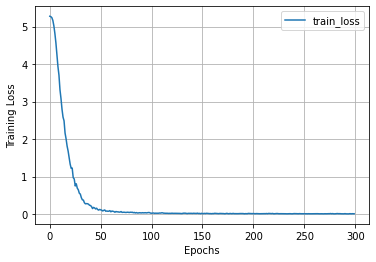

In [27]:
# Show a chart with the training loss
hist = {'train_loss':training_loss,}

df = pd.DataFrame(hist)
ax = df.plot(grid=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Training Loss")
plt.show()

### Evaluating the Model


In [28]:
device = "cpu"
pretrained_model.to(device)

# Let's define a test function to evaluate the model
def test(model):
    # initialize tensor and lists to monitor test loss and accuracy
    test_loss = torch.zeros(1)
    class_correct = list(0. for i in range(196))
    class_total = list(0. for i in range(196))

    test_loss = test_loss.to(device)

    # set the module to evaluation mode
    model.eval()

    for batch_i, data in tqdm(enumerate(test_loader),total=len(test_loader)):
      
        # get the input images and their corresponding labels
        inputs, labels = data

        # move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass to get outputs
        outputs = model(inputs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # update average test loss 
        test_loss = test_loss + ((torch.ones(1).to(device) / (batch_i + 1)) * (loss.data - test_loss))

        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(outputs.data, 1)

        # compare predictions to true label
        # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
        correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))

        # calculate test accuracy for *each* object class
        # we get the scalar value of correct items for a class, by calling `correct[i].item()`
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss:',test_loss.cpu().numpy()[0])

    for i in range(196):
        if class_total[i] > 0:
            print('Test Accuracy of ',train_labels[i],':', 100 * class_correct[i] / class_total[i],'%')
        else:
            print('Test Accuracy of ',train_labels[i],': No training examples')

test(pretrained_model)

100%|█████████████████████████████████████████████| 7/7 [00:14<00:00,  2.02s/it]

Test Loss: 2.4591522
Test Accuracy of  Hyundai_Santa_Fe_SUV_2012 : 75.0 %
Test Accuracy of  Scion_xD_Hatchback_2012 : 58.333333333333336 %
Test Accuracy of  Honda_Accord_Coupe_2012 : 80.0 %
Test Accuracy of  Chrysler_Sebring_Convertible_2010 : 57.142857142857146 %
Test Accuracy of  BMW_X3_SUV_2012 : 63.63636363636363 %
Test Accuracy of  Ford_Freestar_Minivan_2007 : 50.0 %
Test Accuracy of  Land_Rover_LR2_SUV_2012 : 62.5 %
Test Accuracy of  Aston_Martin_V8_Vantage_Coupe_2012 : 0.0 %
Test Accuracy of  Buick_Regal_GS_2012 : 0.0 %
Test Accuracy of  GMC_Savana_Van_2012 : 50.0 %
Test Accuracy of  Audi_S4_Sedan_2012 : 77.77777777777777 %
Test Accuracy of  BMW_M6_Convertible_2010 : 42.857142857142854 %
Test Accuracy of  Cadillac_CTS-V_Sedan_2012 : 44.44444444444444 %
Test Accuracy of  McLaren_MP4-12C_Coupe_2012 : 66.66666666666667 %
Test Accuracy of  BMW_1_Series_Coupe_2012 : 40.0 %
Test Accuracy of  Ford_F-150_Regular_Cab_2012 : 33.333333333333336 %
Test Accuracy of  Chevrolet_Corvette_ZR1_20